In [ ]:
# بسم الله الرحمن الرحیم

In [ ]:
# BaseLine for HDvoicer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**MRH: You may need to downconvert and install some libraries to be compatible with the code**

In [2]:
pip install "librosa==0.9.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [3]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00


**MRH: The Following part is used one time during feature Extraction, So, after one round you can skip this part.
Also, the addresses shouls be modified. since my address correrspond to my google drive.**

In [4]:
# preprocess/tacotron/hyperparams.py

# -*- coding: utf-8 -*-
#/usr/bin/python2
'''
By kyubyong park. kbpark.linguist@gmail.com.
https://www.github.com/kyubyong/tacotron
'''
class Hyperparams:
    '''Hyper parameters'''

    top_db = 15

    # signal processing
    sr = 22050 # Sample rate.
    # n_fft = 2048 # fft points (samples)
    n_fft = 1024 # fft points (samples)
    # frame_shift = 0.0125 # seconds
    # frame_length = 0.05 # seconds
    # hop_length = int(sr*frame_shift) # samples.
    hop_length = 256 # samples.
    # win_length = int(sr*frame_length) # samples.
    win_length = 1024 # samples.
    n_mels = 80 # Number of Mel banks to generate
    power = 1.2 # Exponent for amplifying the predicted magnitude
    n_iter = 100 # Number of inversion iterations
    preemphasis = .97 # or None
    max_db = 100
    ref_db = 20

In [5]:
# to test
hp = Hyperparams()
print(hp.sr)
print(hp.n_mels)

22050
80


In [ ]:
# adaptive_voice_conversion/preprocess/make_datasets_vctk.py

#

import pickle
import librosa
import sys
import glob
import random
import os
from collections import defaultdict
import re
import numpy as np
import json
# from tacotron.utils import get_spectrograms

def read_speaker_info(speaker_info_path):
    speaker_ids = []
    with open(speaker_info_path, 'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            speaker_id = line.strip().split()[0]
            speaker_ids.append(speaker_id)
    return speaker_ids


##### MRH: This is Very Important... using *.flac or *.wav

def read_filenames(root_dir):
    speaker2filenames = defaultdict(lambda : [])
    for path in sorted(glob.glob(os.path.join(root_dir, '*/p*_mic2.flac'))):
        filename = os.path.basename(path)
        match = re.match(r'p(\d+)_(\d+)_mic2\.flac', filename)

        if match:
            # THIS IS THE CRITICAL CHANGE: Prepend 'p' to the captured digits
            speaker_id = 'p' + match.groups()[0]  # match.groups()[0] gets '225', '226', etc.
            # utt_id = match.groups()[1] # You don't use this, but it would be the second group

            speaker2filenames[speaker_id].append(path)
        else:
            print(f"Warning: Filename '{filename}' matched glob but not regex. Skipping. Path: {path}")

    return speaker2filenames

# def read_filenames(root_dir):
#     speaker2filenames = defaultdict(lambda : [])
#     for path in sorted(glob.glob(os.path.join(root_dir, '*/*'))):
#         filename = path.strip().split('/')[-1]
#         speaker_id, utt_id = re.match(r'p(\d+)_(\d+)\.wav', filename).groups()
#         speaker2filenames[speaker_id].append(path)
#     return speaker2filenames


def wave_feature_extraction(wav_file, sr):
    y, sr = librosa.load(wav_file, sr)
    y, _ = librosa.effects.trim(y, top_db=20)
    return y

def spec_feature_extraction(wav_file):
    mel, mag = get_spectrograms(wav_file)
    return mel, mag

if __name__ == '__main__':
    # MRH:
    """
    data_dir = sys.argv[1]
    speaker_info_path = sys.argv[2]
    output_dir = sys.argv[3]
    test_speakers = int(sys.argv[4])
    test_proportion = float(sys.argv[5])
    sample_rate = int(sys.argv[6])
    n_utts_attr = int(sys.argv[7])
    """
    #
    output_dir="/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/"  # MRH: You may modify the address
    data_dir = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental/wav48/" # MRH: You may modify the address
    speaker_info_path = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental/speaker-info.txt" # MRH: You may modify the address
    test_speakers = 20
    test_proportion = 0.1
    n_utt_attr = 5000

    #
    os.makedirs(output_dir, exist_ok=True)
    #


    speaker_ids = read_speaker_info(speaker_info_path)
    random.shuffle(speaker_ids)

    train_speaker_ids = speaker_ids[:-test_speakers]
    test_speaker_ids = speaker_ids[-test_speakers:]

    speaker2filenames = read_filenames(data_dir)

    train_path_list, in_test_path_list, out_test_path_list = [], [], []

    for speaker in train_speaker_ids:
        # print('mrh speaker= ',speaker)
        path_list = speaker2filenames[speaker]
        # print('mrh path_list= ',path_list)
        random.shuffle(path_list)
        test_data_size = int(len(path_list) * test_proportion)
        train_path_list += path_list[:-test_data_size]
        in_test_path_list += path_list[-test_data_size:]

    with open(os.path.join(output_dir, 'in_test_files.txt'), 'w') as f:
        for path in in_test_path_list:
            f.write(f'{path}\n')

    for speaker in test_speaker_ids:
        path_list = speaker2filenames[speaker]
        out_test_path_list += path_list

    with open(os.path.join(output_dir, 'out_test_files.txt'), 'w') as f:
        for path in out_test_path_list:
            f.write(f'{path}\n')

    for dset, path_list in zip(['train', 'in_test', 'out_test'], \
            [train_path_list, in_test_path_list, out_test_path_list]):
        print(f'processing {dset} set, {len(path_list)} files')
        data = {}
        output_path = os.path.join(output_dir, f'{dset}.pkl')
        all_train_data = []
        for i, path in enumerate(sorted(path_list)):
            if i % 500 == 0 or i == len(path_list) - 1:
                print(f'processing {i} files')
            filename = path.strip().split('/')[-1]
            mel, mag = spec_feature_extraction(path)
            data[filename] = mel
            if dset == 'train' and i < n_utts_attr:
                all_train_data.append(mel)



        #
                # In your Colab Cell 1, where you define parameters:
        print(f"n_utt_attr: {n_utt_attr}") # Make sure this is a sensible number, like 1000 or more

        # In your make_datasets_vctk.py script, just before the problematic lines:

        # After speaker_ids = read_speaker_info(speaker_info_path)
        print(f"Total speakers found: {len(speaker_ids)}")
        print(f"First few speaker IDs: {speaker_ids[:5]}")

        # After train_speaker_ids = speaker_ids[:-test_speakers]
        print(f"Number of train speakers: {len(train_speaker_ids)}")
        print(f"Number of test speakers: {len(test_speaker_ids)}")

        # After speaker2filenames = read_filenames(data_dir)
        print(f"Total files found by read_filenames: {sum(len(v) for v in speaker2filenames.values())}")
        # Print a sample of files for a speaker (replace 'pXXX' with a speaker ID you expect to find)
        # if 'p225' in speaker2filenames:
        #    print(f"Sample files for p225: {speaker2filenames['p225'][:5]}")

        # Just before the loop that populates train_path_list:
        print(f"Initial train_path_list length (before populating): {len(train_path_list)}")
        print(f"Initial in_test_path_list length (before populating): {len(in_test_path_list)}")

        # After the loops that populate train_path_list and in_test_path_list:
        print(f"Final train_path_list length: {len(train_path_list)}")
        print(f"Final in_test_path_list length: {len(in_test_path_list)}")
        print(f"Final out_test_path_list length: {len(out_test_path_list)}")
        #

        # raise Exception('Mohammad Reza')





        if dset == 'train':
            all_train_data = np.concatenate(all_train_data)
            mean = np.mean(all_train_data, axis=0)
            std = np.std(all_train_data, axis=0)
            attr = {'mean': mean, 'std': std}
            with open(os.path.join(output_dir, 'attr.pkl'), 'wb') as f:
                pickle.dump(attr, f)
        for key, val in data.items():
            val = (val - mean) / std
            data[key] = val
        with open(output_path, 'wb') as f:
            pickle.dump(data, f)

In [ ]:
# reduce_dataset.py
import pickle
import sys

pkl_path = '/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/train.pkl' # MRH: You may modify the address
segment_size=128
output_path = f'/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/train_{segment_size}.pkl' # MRH: You may modify the address


if __name__ == '__main__':
    # pkl_path = sys.argv[1]
    # output_path = sys.argv[2]
    # segment_size = int(sys.argv[3])

    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    reduced_data = {key:val for key, val in data.items() if val.shape[0] > segment_size}

    with open(output_path, 'wb') as f:
        pickle.dump(reduced_data, f)

In [ ]:
# MRH= This is for train.pkl to produce train_samples_{segment_size}.json
import os

# Configuration variables
training_samples = 10000000
segment_size = 128
pickle_path = '/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/train.pkl'  # MRH: You may modify the address

# Construct sample_path using f-string
sample_path = f'/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/train_samples_{segment_size}.json'  # MRH: You may modify the address


print(f"Configuration set:")
print(f"  Training Samples: {training_samples}")
print(f"  Segment Size: {segment_size}")
print(f"  Pickle Path: {pickle_path}")
print(f"  Sample Path: {sample_path}")

#---------------------#

import json
import pickle
import random

# The variables (training_samples, segment_size, pickle_path, sample_path)
# are assumed to be defined in the previous cell.

# Load the data from the pickle file
print(f"Loading data from {pickle_path}...")
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)
print("Data loaded successfully.")

# (utt_id, timestep)
samples = []

# Filter utterances with length > segment_size
utt_list = [key for key in data]
utt_list = sorted(list(filter(lambda u : len(data[u]) > segment_size, utt_list)))
print(f'{len(utt_list)} utterances meet the segment size criteria.')

# Generate samples
print(f"Generating {training_samples} samples...")
sample_utt_index_list = random.choices(range(len(utt_list)), k=training_samples)

for i, utt_ind in enumerate(sample_utt_index_list):
    if i % 500000 == 0: # Increased frequency for print to avoid too many outputs for large n_samples
        print(f'Sampled {i}/{training_samples} samples...')
    utt_id = utt_list[utt_ind]
    # Ensure t is within valid bounds
    t_max = len(data[utt_id]) - segment_size
    if t_max < 0: # Should not happen if filtered correctly, but good for robustness
        continue
    t = random.randint(0, t_max)
    samples.append((utt_id, t))

# Save the samples to a JSON file
print(f"Saving {len(samples)} samples to {sample_path}...")
with open(sample_path, 'w') as f:
    json.dump(samples, f)
print("Sampling complete and saved.")

In [ ]:
# MRH= This is for in_test.pkl to produce in_test_samples_{segment_size}.json
import os

# Configuration variables
testing_samples = 10000
segment_size = 128
pickle_path = '/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/in_test.pkl' # MRH: You may modify the address

# Construct sample_path using f-string
sample_path = f'/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/in_test_samples_{segment_size}.json' # MRH: You may modify the address


print(f"Configuration set:")
print(f"  Training Samples: {training_samples}")
print(f"  Segment Size: {segment_size}")
print(f"  Pickle Path: {pickle_path}")
print(f"  Sample Path: {sample_path}")

#---------------------#

import json
import pickle
import random

# The variables (testing_samples, segment_size, pickle_path, sample_path)
# are assumed to be defined in the previous cell.

# Load the data from the pickle file
print(f"Loading data from {pickle_path}...")
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)
print("Data loaded successfully.")

# (utt_id, timestep)
samples = []

# Filter utterances with length > segment_size
utt_list = [key for key in data]
utt_list = sorted(list(filter(lambda u : len(data[u]) > segment_size, utt_list)))
print(f'{len(utt_list)} utterances meet the segment size criteria.')

# Generate samples
print(f"Generating {testing_samples} samples...")
sample_utt_index_list = random.choices(range(len(utt_list)), k=testing_samples)

for i, utt_ind in enumerate(sample_utt_index_list):
    if i % 500000 == 0: # Increased frequency for print to avoid too many outputs for large n_samples
        print(f'Sampled {i}/{testing_samples} samples...')
    utt_id = utt_list[utt_ind]
    # Ensure t is within valid bounds
    t_max = len(data[utt_id]) - segment_size
    if t_max < 0: # Should not happen if filtered correctly, but good for robustness
        continue
    t = random.randint(0, t_max)
    samples.append((utt_id, t))

# Save the samples to a JSON file
print(f"Saving {len(samples)} samples to {sample_path}...")
with open(sample_path, 'w') as f:
    json.dump(samples, f)
print("Sampling complete and saved.")


**MRH: As mentioned the Above part are implemented once to extract features, then the following part should be runned every time to produce resultst**

In [6]:
# adaptive_voice_conversion /utils.py
import torch
import numpy as np
from tensorboardX import SummaryWriter
import editdistance
import torch.nn as nn
import torch.nn.init as init

def cc(net):
    # print('100')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print('200')
    return net.to(device)

class Logger(object):
    def __init__(self, logdir='./log'):
        self.writer = SummaryWriter(logdir)

    def scalar_summary(self, tag, value, step):
        self.writer.add_scalar(tag, value, step)

    def scalars_summary(self, tag, dictionary, step):
        self.writer.add_scalars(tag, dictionary, step)

    def text_summary(self, tag, value, step):
        self.writer.add_text(tag, value, step)

    def audio_summary(self, tag, value, step, sr):
        writer.add_audio(tag, value, step, sample_rate=sr)

def infinite_iter(iterable):
    it = iter(iterable)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(iterable)

In [ ]:
##### Model

In [7]:
# adaptive_voice_conversion/model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import numpy as np
from math import ceil
from functools import reduce
from torch.nn.utils import spectral_norm
# from utils import cc

class DummyEncoder(object):
    def __init__(self, encoder):
        self.encoder = encoder

    def load(self, target_network):
        self.encoder.load_state_dict(target_network.state_dict())

    def __call__(self, x):
        return self.encoder(x)

def pad_layer(inp, layer, pad_type='reflect'):
    kernel_size = layer.kernel_size[0]
    if kernel_size % 2 == 0:
        pad = (kernel_size//2, kernel_size//2 - 1)
    else:
        pad = (kernel_size//2, kernel_size//2)
    # padding
    inp = F.pad(inp,
            pad=pad,
            mode=pad_type)
    out = layer(inp)
    return out

def pad_layer_2d(inp, layer, pad_type='reflect'):
    kernel_size = layer.kernel_size
    if kernel_size[0] % 2 == 0:
        pad_lr = [kernel_size[0]//2, kernel_size[0]//2 - 1]
    else:
        pad_lr = [kernel_size[0]//2, kernel_size[0]//2]
    if kernel_size[1] % 2 == 0:
        pad_ud = [kernel_size[1]//2, kernel_size[1]//2 - 1]
    else:
        pad_ud = [kernel_size[1]//2, kernel_size[1]//2]
    pad = tuple(pad_lr + pad_ud)
    # padding
    inp = F.pad(inp,
            pad=pad,
            mode=pad_type)
    out = layer(inp)
    return out

def pixel_shuffle_1d(inp, scale_factor=2):
    batch_size, channels, in_width = inp.size()
    channels //= scale_factor
    out_width = in_width * scale_factor
    inp_view = inp.contiguous().view(batch_size, channels, scale_factor, in_width)
    shuffle_out = inp_view.permute(0, 1, 3, 2).contiguous()
    shuffle_out = shuffle_out.view(batch_size, channels, out_width)
    return shuffle_out

def upsample(x, scale_factor=2):
    x_up = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
    return x_up

def flatten(x):
    out = x.contiguous().view(x.size(0), x.size(1) * x.size(2))
    return out

def concat_cond(x, cond):
    # x = [batch_size, x_channels, length]
    # cond = [batch_size, c_channels]
    cond = cond.unsqueeze(dim=2)
    cond = cond.expand(*cond.size()[:-1], x.size(-1))
    out = torch.cat([x, cond], dim=1)
    return out

def append_cond(x, cond):
    # x = [batch_size, x_channels, length]
    # cond = [batch_size, x_channels * 2]
    p = cond.size(1) // 2
    mean, std = cond[:, :p], cond[:, p:]
    out = x * std.unsqueeze(dim=2) + mean.unsqueeze(dim=2)
    return out

def conv_bank(x, module_list, act, pad_type='reflect'):
    outs = []
    for layer in module_list:
        out = act(pad_layer(x, layer, pad_type))
        outs.append(out)
    out = torch.cat(outs + [x], dim=1)
    return out

def get_act(act):
    if act == 'relu':
        return nn.ReLU()
    elif act == 'lrelu':
        return nn.LeakyReLU()
    else:
        return nn.ReLU()

class MLP(nn.Module):
    def __init__(self, c_in, c_h, n_blocks, act, sn):
        super(MLP, self).__init__()
        self.act = get_act(act)
        self.n_blocks = n_blocks
        f = spectral_norm if sn else lambda x: x
        self.in_dense_layer = f(nn.Linear(c_in, c_h))
        self.first_dense_layers = nn.ModuleList([f(nn.Linear(c_h, c_h)) for _ in range(n_blocks)])
        self.second_dense_layers = nn.ModuleList([f(nn.Linear(c_h, c_h)) for _ in range(n_blocks)])

    def forward(self, x):
        h = self.in_dense_layer(x)
        for l in range(self.n_blocks):
            y = self.first_dense_layers[l](h)
            y = self.act(y)
            y = self.second_dense_layers[l](y)
            y = self.act(y)
            h = h + y
        return h

class Prenet(nn.Module):
    def __init__(self, c_in, c_h, c_out,
            kernel_size, n_conv_blocks,
            subsample, act, dropout_rate):
        super(Prenet, self).__init__()
        self.act = get_act(act)
        self.subsample = subsample
        self.n_conv_blocks = n_conv_blocks
        self.in_conv_layer = nn.Conv2d(1, c_h, kernel_size=kernel_size)
        self.first_conv_layers = nn.ModuleList([nn.Conv2d(c_h, c_h, kernel_size=kernel_size) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([nn.Conv2d(c_h, c_h, kernel_size=kernel_size, stride=sub)
            for sub, _ in zip(subsample, range(n_conv_blocks))])
        output_size = c_in
        for l, sub in zip(range(n_conv_blocks), self.subsample):
            output_size = ceil(output_size / sub)
        self.out_conv_layer = nn.Conv1d(c_h * output_size, c_out, kernel_size=1)
        self.dropout_layer = nn.Dropout(p=dropout_rate)
        self.norm_layer = nn.InstanceNorm2d(c_h, affine=False)

    def forward(self, x):
        # reshape x to 4D
        x = x.contiguous().view(x.size(0), 1, x.size(1), x.size(2))
        out = pad_layer_2d(x, self.in_conv_layer)
        out = self.act(out)
        out = self.norm_layer(out)
        for l in range(self.n_conv_blocks):
            y = pad_layer_2d(out, self.first_conv_layers[l])
            y = self.act(y)
            y = self.norm_layer(y)
            y = self.dropout_layer(y)
            y = pad_layer_2d(y, self.second_conv_layers[l])
            y = self.act(y)
            y = self.norm_layer(y)
            y = self.dropout_layer(y)
            if self.subsample[l] > 1:
                out = F.avg_pool2d(out, kernel_size=self.subsample[l], ceil_mode=True)
            out = y + out
        out = out.contiguous().view(out.size(0), out.size(1) * out.size(2), out.size(3))
        out = pad_layer(out, self.out_conv_layer)
        out = self.act(out)
        return out

class Postnet(nn.Module):
    def __init__(self, c_in, c_h, c_out, c_cond,
            kernel_size, n_conv_blocks,
            upsample, act, sn):
        super(Postnet, self).__init__()
        self.act = get_act(act)
        self.upsample = upsample
        self.c_h = c_h
        self.n_conv_blocks = n_conv_blocks
        f = spectral_norm if sn else lambda x: x
        total_upsample = reduce(lambda x, y: x*y, upsample)
        self.in_conv_layer = f(nn.Conv1d(c_in, c_h * c_out // total_upsample, kernel_size=1))
        self.first_conv_layers = nn.ModuleList([f(nn.Conv2d(c_h, c_h, kernel_size=kernel_size)) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([f(nn.Conv2d(c_h, c_h*up*up, kernel_size=kernel_size))
            for up, _ in zip(upsample, range(n_conv_blocks))])
        self.out_conv_layer = f(nn.Conv2d(c_h, 1, kernel_size=1))
        self.conv_affine_layers = nn.ModuleList(
                [f(nn.Linear(c_cond, c_h * 2)) for _ in range(n_conv_blocks*2)])
        self.norm_layer = nn.InstanceNorm2d(c_h, affine=False)
        self.ps = nn.PixelShuffle(max(upsample))

    def forward(self, x, cond):
        out = pad_layer(x, self.in_conv_layer)
        out = out.contiguous().view(out.size(0), self.c_h, out.size(1) // self.c_h, out.size(2))
        for l in range(self.n_conv_blocks):
            y = pad_layer_2d(out, self.first_conv_layers[l])
            y = self.act(y)
            y = self.norm_layer(y)
            y = append_cond_2d(y, self.conv_affine_layers[l*2](cond))
            y = pad_layer_2d(y, self.second_conv_layers[l])
            y = self.act(y)
            if self.upsample[l] > 1:
                y = self.ps(y)
                y = self.norm_layer(y)
                y = append_cond_2d(y, self.conv_affine_layers[l*2+1](cond))
                out = y + upsample(out, scale_factor=(self.upsample[l], self.upsample[l]))
            else:
                y = self.norm_layer(y)
                y = append_cond(y, self.conv_affine_layers[l*2+1](cond))
                out = y + out
        out = self.out_conv_layer(out)
        out = out.squeeze(dim=1)
        return out


In [8]:
class SpeakerEncoder1(nn.Module):
    def __init__(self, c_in, c_h, c_out, kernel_size,
            bank_size, bank_scale, c_bank,
            n_conv_blocks, n_dense_blocks,
            subsample, act, dropout_rate,
            use_hierarchy=False, n_levels=1):
        super(SpeakerEncoder1, self).__init__()
        self.c_in = c_in
        self.c_h = c_h
        self.c_out = c_out # Dimension for each individual latent level (z1, z2, etc.)
        self.kernel_size = kernel_size
        self.n_conv_blocks = n_conv_blocks
        self.n_dense_blocks = n_dense_blocks
        self.subsample = subsample
        self.act = get_act(act)
        self.use_hierarchy = use_hierarchy
        self.n_levels = n_levels

        self.conv_bank = nn.ModuleList(
                [nn.Conv1d(c_in, c_bank, kernel_size=k) for k in range(bank_scale, bank_size + 1, bank_scale)])
        in_channels = c_bank * (bank_size // bank_scale) + c_in
        self.in_conv_layer = nn.Conv1d(in_channels, c_h, kernel_size=1)

        # Convolutional blocks
        self.first_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size) for _ in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size, stride=sub) for sub in subsample])

        self.pooling_layer = nn.AdaptiveAvgPool1d(1)

        # Dense blocks
        self.first_dense_layers = nn.ModuleList([nn.Linear(c_h, c_h) for _ in range(n_dense_blocks)])
        self.second_dense_layers = nn.ModuleList([nn.Linear(c_h, c_h) for _ in range(n_dense_blocks)])

        if self.use_hierarchy:
            # For each level (z1, z2, ..., zn), we need posterior mu and log_sigma layers
            # All levels have c_out dimensions
            self.mu_layers = nn.ModuleList([nn.Linear(c_h, c_out) for _ in range(n_levels)])
            self.log_sigma_layers = nn.ModuleList([nn.Linear(c_h, c_out) for _ in range(n_levels)])

            # Prior predictor layers: `prior_predictor_layers[k]` maps from z_{k+1} to prior params for z_k
            # e.g., prior_predictor_layers[0] for z1_prior from z2.
            #       prior_predictor_layers[1] for z2_prior from z3.
            self.prior_predictor_layers = nn.ModuleList()
            for _ in range(n_levels - 1): # (n_levels - 1) prior networks needed
                self.prior_predictor_layers.append(nn.Sequential(
                    nn.Linear(c_out, c_h),
                    self.act,
                    nn.Linear(c_h, c_out * 2) # For mu_prior and log_sigma_prior
                ))
        else:
            self.output_layer = nn.Linear(c_h, c_out)

        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def conv_blocks(self, inp):
        out = inp
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.subsample[l] > 1:
                out = F.avg_pool1d(out, kernel_size=self.subsample[l], ceil_mode=True)
            out = y + out # Residual connection
        return out

    def dense_blocks(self, inp):
        out = inp
        for l in range(self.n_dense_blocks):
            y = self.first_dense_layers[l](out)
            y = self.act(y)
            y = self.dropout_layer(y)
            y = self.second_dense_layers[l](y)
            y = self.act(y)
            y = self.dropout_layer(y)
            out = y + out # Residual connection
        return out

    def forward(self, x):
        out = conv_bank(x, self.conv_bank, act=self.act)
        out = pad_layer(out, self.in_conv_layer)
        out = self.act(out)
        out = self.conv_blocks(out)
        out = self.pooling_layer(out).squeeze(2) # Shape: (batch_size, c_h)
        pooled_features = self.dense_blocks(out) # pooled_features is (batch_size, c_h)

        if self.use_hierarchy:
            mus = []
            log_sigmas = []
            mu_priors = [] # [None (for z1), prior for z2 (from z1), prior for z3 (from z2)]
            log_sigma_priors = [] # Same
            sampled_latents = []

            # --- For z1 (Highest Level - standard normal prior) ---
            # Posterior for z1 from pooled_features
            mu_post_z1 = self.mu_layers[0](pooled_features)
            log_sigma_post_z1 = self.log_sigma_layers[0](pooled_features)

            # Sample z1
            eps_z1 = torch.randn_like(mu_post_z1)
            z1 = mu_post_z1 + torch.exp(log_sigma_post_z1 * 0.5) * eps_z1

            mus.append(mu_post_z1)
            log_sigmas.append(log_sigma_post_z1)
            sampled_latents.append(z1)

            # Prior for z1 is standard normal (N(0,I))
            mu_priors.append(None)
            log_sigma_priors.append(None)

            # --- For subsequent levels (z2, z3, etc.) ---
            # Loop from the second level (index 1) up to n_levels-1
            for i in range(1, self.n_levels):
                # Posterior for z_{i+1} from pooled_features
                mu_post_zi = self.mu_layers[i](pooled_features)
                log_sigma_post_zi = self.log_sigma_layers[i](pooled_features)

                # Sample z_{i+1}
                eps_zi = torch.randn_like(mu_post_zi)
                zi = mu_post_zi + torch.exp(log_sigma_post_zi * 0.5) * eps_zi

                mus.append(mu_post_zi)
                log_sigmas.append(log_sigma_post_zi)
                sampled_latents.append(zi) # sampled_latents[i] is z_{i+1}

                # Compute prior for z_{i+1} from z_i (sampled_latents[i-1])
                prior_params = self.prior_predictor_layers[i-1](sampled_latents[i-1])
                mu_prior_zi, log_sigma_prior_zi = prior_params.chunk(2, dim=-1)

                mu_priors.append(mu_prior_zi)
                log_sigma_priors.append(log_sigma_prior_zi)

            # The decoder input for speaker is the concatenation of all sampled speaker latents
            decoder_input_emb = torch.cat(sampled_latents, dim=-1)

            return {
                'mus': mus, # List of posterior means [mu_z1, mu_z2, mu_z3]
                'log_sigmas': log_sigmas, # List of posterior log_sigmas [log_sigma_z1, log_sigma_z2, log_sigma_z3]
                'mu_priors': mu_priors, # List of priors [None (for z1), prior_z2_from_z1, prior_z3_from_z2]
                'log_sigma_priors': log_sigma_priors, # Same
                'decoder_input': decoder_input_emb # Concatenated speaker embedding (z1 || z2 || z3 ...)
            }

        else:
            # Original non-hierarchical output remains the same
            emb = self.output_layer(pooled_features)
            return {
                'mus': [emb],
                'log_sigmas': [torch.zeros_like(emb)],
                'mu_priors': [None],
                'log_sigma_priors': [None],
                'decoder_input': emb
            }

In [9]:
class ContentEncoder1(nn.Module):
    def __init__(self, c_in, c_h, c_out, kernel_size,
            bank_size, bank_scale, c_bank,
            n_conv_blocks, subsample,
            act, dropout_rate,
            use_hierarchy=False, n_levels=1):
        super(ContentEncoder1, self).__init__()
        self.n_conv_blocks = n_conv_blocks
        self.subsample = subsample
        self.act = get_act(act)
        self.use_hierarchy = use_hierarchy
        self.n_levels = n_levels
        self.c_out = c_out # Dimension for each individual latent level (z1, z2, etc.)

        self.conv_bank = nn.ModuleList(
                [nn.Conv1d(c_in, c_bank, kernel_size=k) for k in range(bank_scale, bank_size + 1, bank_scale)])
        in_channels = c_bank * (bank_size // bank_scale) + c_in
        self.in_conv_layer = nn.Conv1d(in_channels, c_h, kernel_size=1)
        self.first_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size) for _ in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size, stride=sub) for sub in subsample])
        self.norm_layer = nn.InstanceNorm1d(c_h, affine=False)
        self.dropout_layer = nn.Dropout(p=dropout_rate)

        if self.use_hierarchy:
            # For each level (z1, z2, ..., zn), we need posterior mu and log_sigma layers
            # All levels have c_out dimensions
            self.mu_layers = nn.ModuleList([nn.Conv1d(c_h, c_out, kernel_size=1) for _ in range(n_levels)])
            self.log_sigma_layers = nn.ModuleList([nn.Conv1d(c_h, c_out, kernel_size=1) for _ in range(n_levels)])

            # Prior predictor layers: `prior_predictor_layers[k]` maps from z_{k+1} to prior params for z_k
            self.prior_predictor_layers = nn.ModuleList()
            for _ in range(n_levels - 1):
                self.prior_predictor_layers.append(nn.Sequential(
                    nn.Conv1d(c_out, c_h, kernel_size=1),
                    self.act,
                    nn.Conv1d(c_h, c_out * 2, kernel_size=1)
                ))
        else:
            self.mean_layer = nn.Conv1d(c_h, c_out, kernel_size=1)
            self.std_layer = nn.Conv1d(c_h, c_out, kernel_size=1)

    def forward(self, x):
        out = conv_bank(x, self.conv_bank, act=self.act)
        out = pad_layer(out, self.in_conv_layer) # This is correct for in_conv_layer
        out = self.norm_layer(out)
        out = self.act(out)
        out = self.dropout_layer(out)
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l]) # Correct
            y = self.norm_layer(y)
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l]) # Correct
            y = self.norm_layer(y)
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.subsample[l] > 1:
                out = F.avg_pool1d(out, kernel_size=self.subsample[l], ceil_mode=True)
            out = y + out # Residual connection

        processed_features = out # (batch_size, c_h, seq_len)

        if self.use_hierarchy:
            mus = []
            log_sigmas = []
            mu_priors = [] # [None (for z1), prior for z2 (from z1), prior for z3 (from z2)]
            log_sigma_priors = [] # Same
            sampled_latents = []

            # --- For z1 (Highest Level - standard normal prior) ---
            # Posterior for z1 from processed_features
            # These are 1x1 convs, no need for external pad_layer.
            mu_post_z1 = self.mu_layers[0](processed_features)
            log_sigma_post_z1 = self.log_sigma_layers[0](processed_features)

            # Sample z1
            eps_z1 = torch.randn_like(mu_post_z1)
            z1 = mu_post_z1 + torch.exp(log_sigma_post_z1 * 0.5) * eps_z1

            mus.append(mu_post_z1)
            log_sigmas.append(log_sigma_post_z1)
            sampled_latents.append(z1)

            # Prior for z1 is standard normal (N(0,I))
            mu_priors.append(None)
            log_sigma_priors.append(None)

            # --- For subsequent levels (z2, z3, etc.) ---
            # Loop from the second level (index 1) up to n_levels-1
            for i in range(1, self.n_levels):
                # Posterior for z_{i+1} from processed_features
                # These are 1x1 convs, no need for external pad_layer.
                mu_post_zi = self.mu_layers[i](processed_features)
                log_sigma_post_zi = self.log_sigma_layers[i](processed_features)

                # Sample z_{i+1}
                eps_zi = torch.randn_like(mu_post_zi)
                zi = mu_post_zi + torch.exp(log_sigma_post_zi * 0.5) * eps_zi

                mus.append(mu_post_zi)
                log_sigmas.append(log_sigma_post_zi)
                sampled_latents.append(zi) # sampled_latents[i] is z_{i+1}

                # Compute prior for z_{i+1} from z_i (sampled_latents[i-1])
                # prior_predictor_layers[0] for z2's prior from z1
                # prior_predictor_layers[1] for z3's prior from z2
                # So, prior_predictor_layers[i-1] takes sampled_latents[i-1] (z_i)
                # FIX: Remove pad_layer here. Just call the Sequential module directly.
                prior_params = self.prior_predictor_layers[i-1](sampled_latents[i-1])
                mu_prior_zi, log_sigma_prior_zi = prior_params.chunk(2, dim=1)

                mu_priors.append(mu_prior_zi)
                log_sigma_priors.append(log_sigma_prior_zi)

            # The decoder input is always z1 (the highest level latent)
            decoder_input_content = sampled_latents[0]

            return {
                'mus': mus, # List of posterior means [mu_z1, mu_z2, mu_z3]
                'log_sigmas': log_sigmas, # List of posterior log_sigmas [log_sigma_z1, log_sigma_z2, log_sigma_z3]
                'mu_priors': mu_priors, # List of priors [None (for z1), prior_z2_from_z1, prior_z3_from_z2]
                'log_sigma_priors': log_sigma_priors, # Same
                'decoder_input': decoder_input_content # z1 only
            }

        else:
            # Original non-hierarchical output remains the same
            # These are 1x1 convs, no need for external pad_layer.
            mu = self.mean_layer(processed_features)
            log_sigma = self.std_layer(processed_features)

            eps = torch.randn_like(mu)
            z = mu + torch.exp(log_sigma * 0.5) * eps

            return {
                'mus': [mu],
                'log_sigmas': [log_sigma],
                'mu_priors': [None],
                'log_sigma_priors': [None],
                'decoder_input': z
            }

In [10]:
class Decoder(nn.Module):
    def __init__(self,
            c_in, c_cond, c_h, c_out,
            kernel_size,
            n_conv_blocks, upsample, act, sn, dropout_rate):
        super(Decoder, self).__init__()
        self.n_conv_blocks = n_conv_blocks
        self.upsample = upsample
        self.act = get_act(act)
        f = spectral_norm if sn else lambda x: x
        self.in_conv_layer = f(nn.Conv1d(c_in, c_h, kernel_size=1))
        self.first_conv_layers = nn.ModuleList([f(nn.Conv1d(c_h, c_h, kernel_size=kernel_size)) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList(\
                [f(nn.Conv1d(c_h, c_h * up, kernel_size=kernel_size)) \
                for _, up in zip(range(n_conv_blocks), self.upsample)])
        self.norm_layer = nn.InstanceNorm1d(c_h, affine=False)
        self.conv_affine_layers = nn.ModuleList(
                [f(nn.Linear(c_cond, c_h * 2)) for _ in range(n_conv_blocks*2)])
        self.out_conv_layer = f(nn.Conv1d(c_h, c_out, kernel_size=1))
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, z, cond):
        out = pad_layer(z, self.in_conv_layer)
        out = self.norm_layer(out)
        out = self.act(out)
        out = self.dropout_layer(out)
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.norm_layer(y)
            y = append_cond(y, self.conv_affine_layers[l*2](cond))
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            if self.upsample[l] > 1:
                y = pixel_shuffle_1d(y, scale_factor=self.upsample[l])
            y = self.norm_layer(y)
            y = append_cond(y, self.conv_affine_layers[l*2+1](cond))
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.upsample[l] > 1:
                out = y + upsample(out, scale_factor=self.upsample[l])
            else:
                out = y + out
        out = pad_layer(out, self.out_conv_layer)
        return out


In [11]:
class AE1(nn.Module):
    def __init__(self,  args):
        super(AE1, self).__init__()
        self.use_content_hierarchy = args.use_content_hierarchy
        self.n_content_levels = args.n_content_levels if args.use_content_hierarchy else 1
        self.use_speaker_hierarchy = args.use_speaker_hierarchy
        self.n_speaker_levels = args.n_speaker_levels if args.use_speaker_hierarchy else 1

        # Configure SpeakerEncoder
        speaker_encoder_config = args.config['SpeakerEncoder'].copy()
        speaker_encoder_config['use_hierarchy'] = self.use_speaker_hierarchy
        speaker_encoder_config['n_levels'] = self.n_speaker_levels
        self.speaker_encoder = SpeakerEncoder1(**speaker_encoder_config)

        # Configure ContentEncoder
        content_encoder_config = args.config['ContentEncoder'].copy()
        content_encoder_config['use_hierarchy'] = self.use_content_hierarchy
        content_encoder_config['n_levels'] = self.n_content_levels
        self.content_encoder = ContentEncoder1(**content_encoder_config)

        # Configure Decoder
        decoder_config = args.config['Decoder'].copy()

        # Dynamically set c_in for decoder (input from ContentEncoder)
        decoder_config['c_in'] = content_encoder_config['c_out'] # z1 of content is always c_out

        # Dynamically set c_cond for decoder (input from SpeakerEncoder)
        if self.use_speaker_hierarchy:
            # Speaker decoder input is the concatenation of all speaker latents (z1 || z2 || z3 ...)
            decoder_config['c_cond'] = speaker_encoder_config['c_out'] * self.n_speaker_levels
        else:
            decoder_config['c_cond'] = speaker_encoder_config['c_out']

        self.decoder = Decoder(**decoder_config)

    def forward(self, x):
        speaker_latents_info = self.speaker_encoder(x)
        content_latents_info = self.content_encoder(x)

        # Decoder receives the specific 'decoder_input' from the encoder.
        # For speaker, it's the concatenated embedding.
        # For content, it's z1.
        speaker_decoder_input = speaker_latents_info['decoder_input']
        content_decoder_input = content_latents_info['decoder_input']

        dec = self.decoder(content_decoder_input, speaker_decoder_input)

        return {
            'dec': dec,
            'speaker_latents': speaker_latents_info,
            'content_latents': content_latents_info,
        }

    def inference(self, x, x_cond):
        speaker_latents_info = self.speaker_encoder(x_cond)
        content_latents_info = self.content_encoder(x)

        # For inference, use the posterior mean (mu) of z1 for content, as z1 is reconstructed.
        content_decoder_input = content_latents_info['mus'][0]

        # For speaker, use the `decoder_input` which is the concatenated embedding.
        speaker_decoder_input = speaker_latents_info['decoder_input']

        dec = self.decoder(content_decoder_input, speaker_decoder_input)
        return dec

    def get_speaker_embeddings(self, x):
        # This function should return the final speaker embedding used by the decoder.
        speaker_latents_info = self.speaker_encoder(x)
        return speaker_latents_info['decoder_input']

In [ ]:
#######################
###### Code    ########
#######################

In [12]:
#adaptive_voice_conversion/data_utils.py
import torch
from torch.utils.data import Dataset
import os
import pickle
import json
import numpy as np
import torch
from torch.utils.data import DataLoader

class CollateFn(object):
    def __init__(self, frame_size):
        self.frame_size = frame_size

    def make_frames(self, tensor):
        out = tensor.view(tensor.size(0), tensor.size(1) // self.frame_size, self.frame_size * tensor.size(2))
        out = out.transpose(1, 2)
        return out

    def __call__(self, l):
        data_tensor = torch.from_numpy(np.array(l))
        segment = self.make_frames(data_tensor)
        return segment

def get_data_loader(dataset, batch_size, frame_size, shuffle=True, num_workers=4, drop_last=False):
    _collate_fn = CollateFn(frame_size=frame_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
            num_workers=num_workers, collate_fn=_collate_fn, pin_memory=True)
    return dataloader

class SequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.utt_ids = list(self.data.keys())

    def __getitem__(self, ind):
        utt_id = self.utt_ids[ind]
        ret = self.data[utt_id].transpose()
        return ret

    def __len__(self):
        return len(self.utt_ids)

class PickleDataset(Dataset):
    def __init__(self, pickle_path, sample_index_path, segment_size):
        with open(pickle_path, 'rb') as f:
            self.data = pickle.load(f)
        with open(sample_index_path, 'r') as f:
            self.indexes = json.load(f)
        self.segment_size = segment_size

    def __getitem__(self, ind):
        utt_id, t = self.indexes[ind]
        segment = self.data[utt_id][t:t + self.segment_size]
        return segment

    def __len__(self):
        return len(self.indexes)


In [13]:
import torch
import torch.nn.functional as F

class AELoss:
    def __init__(self, n_speaker_levels: int, n_content_levels: int):
        """
        Initializes the AELoss class.

        Args:
            n_speaker_levels: Number of speaker hierarchy levels.
            n_content_levels: Number of content hierarchy levels.
        """
        self.n_speaker_levels = n_speaker_levels
        self.n_content_levels = n_content_levels

    def calculate_kld(self, mu_post, log_sigma_post, mu_prior=None, log_sigma_prior=None):
        """
        Calculates the Kullback-Leibler Divergence (KLD).
        """
        if mu_prior is None or log_sigma_prior is None:
            # Standard normal prior (N(0, I))
            kld = -0.5 * torch.sum(1 + log_sigma_post - mu_post.pow(2) - log_sigma_post.exp())
        else:
            # Gaussian prior (N(mu_prior, exp(log_sigma_prior)))
            kld = 0.5 * torch.sum(
                torch.exp(log_sigma_post - log_sigma_prior) +
                ((mu_prior - mu_post)**2) * torch.exp(-log_sigma_prior) - 1 +
                (log_sigma_prior - log_sigma_post)
            )
        return kld

    def speaker_kld_loss(self, speaker_latents):
        """
        Calculates the KLD loss for the speaker hierarchy.
        """
        speaker_kld_loss = 0
        for i in range(self.n_speaker_levels):
            mu_post = speaker_latents['mus'][i]
            log_sigma_post = speaker_latents['log_sigmas'][i]
            mu_prior = speaker_latents['mu_priors'][i]
            log_sigma_prior = speaker_latents['log_sigma_priors'][i]
            speaker_kld_loss += self.calculate_kld(mu_post, log_sigma_post, mu_prior, log_sigma_prior)
        return speaker_kld_loss

    def content_kld_loss(self, content_latents):
        """
        Calculates the KLD loss for the content hierarchy.
        """
        content_kld_loss = 0
        for i in range(self.n_content_levels):
            mu_post = content_latents['mus'][i]
            log_sigma_post = content_latents['log_sigmas'][i]
            mu_prior = content_latents['mu_priors'][i]
            log_sigma_prior = content_latents['log_sigma_priors'][i]
            content_kld_loss += self.calculate_kld(mu_post, log_sigma_post, mu_prior, log_sigma_prior)
        return content_kld_loss

    def loss_calculate(self, x, dec, speaker_latents, content_latents, lambda_kl: float = 1.0):
        """
        Calculates the total loss for the Autoencoder.

        Args:
            x: Original input tensor.
            dec: Reconstructed output tensor from the decoder.
            speaker_latents: Dictionary containing speaker latent distributions.
            content_latents: Dictionary containing content latent distributions.
            lambda_kl: Weight for the KLD loss components.

        Returns:
            A dictionary containing individual and total loss components.
        """
        # Reconstruction Loss (e.g., L1)
        recon_loss = F.l1_loss(dec, x)

        speaker_kld_loss = self.speaker_kld_loss(speaker_latents)
        content_kld_loss = self.content_kld_loss(content_latents)

        # Total Loss with KLD weighting
        total_loss = recon_loss + lambda_kl * (speaker_kld_loss + content_kld_loss)

        return {
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'speaker_kld_loss': speaker_kld_loss,
            'content_kld_loss': content_kld_loss
        }

In [14]:
import yaml

class ARGS1():
  def __init__(self):
    # Store the YAML content directly as a string
    self.config_content = """
SpeakerEncoder:
    c_in: 80
    c_h: 128
    c_out: 128
    kernel_size: 5
    bank_size: 8
    bank_scale: 1
    c_bank: 128
    n_conv_blocks: 6
    n_dense_blocks: 6
    subsample: [1, 2, 1, 2, 1, 2]
    act: 'relu'
    dropout_rate: 0
ContentEncoder:
    c_in: 80
    c_h: 128
    c_out: 128
    kernel_size: 5
    bank_size: 8
    bank_scale: 1
    c_bank: 128
    n_conv_blocks: 6
    subsample: [1, 2, 1, 2, 1, 2]
    act: 'relu'
    dropout_rate: 0
Decoder:
    c_in: 128
    c_cond: 128
    c_h: 128
    c_out: 80
    kernel_size: 5
    n_conv_blocks: 6
    upsample: [2, 1, 2, 1, 2, 1]
    act: 'relu'
    sn: False
    dropout_rate: 0
data_loader:
    segment_size: 128
    frame_size: 1
    batch_size: 128
    shuffle: True
optimizer:
    lr: 0.0005
    beta1: 0.9
    beta2: 0.999
    amsgrad: True
    weight_decay: 0.0001
    grad_norm: 5
lambda:
    lambda_rec: 10
    lambda_kl: 1
annealing_iters: 20000
    """
    self.data_dir='/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/' # MRH: You may Modify the part
    self.train_set='train_128'
    self.train_index_file='train_samples_128.json'
    self.logdir='log/'
    self.load_model=False
    self.store_model_path='/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/checkpoint' # MRH: You may Modify the part
    self.load_model_path='/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/checkpoint' # MRH: You may Modify the part
    self.summary_steps=500
    self.save_steps=50
    self.tag='vctk_model'
    self.iters=100000

    #  Hierarchy

    self.use_content_hierarchy=True
    self.n_content_levels=3 # MRH: in the AE1,  if use_content_hierarchy= True then n_content_levels gets number else it is 1
    self.use_speaker_hierarchy=True
    self.n_speaker_levels=3 # MRH: in the AE1,  if use_speaker_hierarchy= True then n_content_levels gets number else it is 1

    # Parse the YAML content into a dictionary
    self.config = yaml.safe_load(self.config_content)

##
args1=ARGS1()
print(args1.train_index_file)
print(args1.data_dir)

# Now you can access your config parameters like this:
print("\nAccessing config parameters:")
print(args1.config['SpeakerEncoder']['c_in'])
print(args1.config['data_loader']['batch_size'])

train_samples_128.json
/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/

Accessing config parameters:
80
128


 **Performing Speaker Verification**

**MRH: to include speaker id in output of reading data**

In [15]:
# 1. Modify PickleDataset's __getitem__ to return both utt_id and segment:

class PickleDataset(Dataset):
    def __init__(self, pickle_path, sample_index_path, segment_size):
        with open(pickle_path, 'rb') as f:
            self.data = pickle.load(f)
        with open(sample_index_path, 'r') as f:
            self.indexes = json.load(f)
        self.segment_size = segment_size

    def __getitem__(self, ind):
        utt_id, t = self.indexes[ind]
        segment = self.data[utt_id][t:t + self.segment_size]
        return segment, utt_id  ###### MRH: This is the change: Return both segment and utt_id

    def __len__(self):
        return len(self.indexes)

In [16]:
# 2. Modify CollateFn's __call__ to handle both utt_id and segment
class CollateFn(object):
    def __init__(self, frame_size):
        self.frame_size = frame_size

    def make_frames(self, tensor):
        out = tensor.view(tensor.size(0), tensor.size(1) // self.frame_size, self.frame_size * tensor.size(2))
        out = out.transpose(1, 2)
        return out

    def __call__(self, l):
        # l will be a list of (segment, utt_id) tuples from PickleDataset's __getitem__
        # Correctly extract segments (numerical data) and utt_ids (strings)
        numerical_segments = [item[0] for item in l] # This should be the numerical data
        utt_ids = [item[1] for item in l]           # This should be the string utt_id

        # Now, numerical_segments should be a list of NumPy arrays or similar,
        # which can be converted to a single NumPy array and then to a torch.Tensor.
        data_tensor = torch.from_numpy(np.array(numerical_segments))
        segment = self.make_frames(data_tensor)

        # Return the processed numerical segment tensor and the list of utt_ids
        return segment, utt_ids # MRH: Return both segment and utt_id

**Speaker Verification Class**

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm
import itertools # For generating pairs

class SpeakerVerificationEvaluator:
    def __init__(self, device='cpu'):
        """
        Initializes the SpeakerVerificationEvaluator.

        Args:
            device (str): The device to perform calculations on ('cuda' or 'cpu').
        """
        self.device = torch.device(device)

    def _extract_speaker_id_from_filename(self, utt_id_filename):
        """
        Extracts the speaker ID from a filename like 'p229_018.wav'.
        Assumes the speaker ID is the first part before the first underscore.
        """
        if not isinstance(utt_id_filename, str):
            raise TypeError(f"Expected utt_id_filename to be a string, but got {type(utt_id_filename)}")
        return utt_id_filename.split('_')[0]

    def _calculate_cosine_similarities(self, embeddings, speaker_ids_or_filenames):
        """
        Calculates cosine similarities for all possible pairs of embeddings.

        Args:
            embeddings (list of torch.Tensor): List of individual speaker embedding tensors.
                                               Each tensor should be 1-D, e.g., (embedding_dim,).
            speaker_ids_or_filenames (list): List of corresponding speaker IDs (strings)
                                             OR filenames (strings) from which IDs can be extracted.

        Returns:
            tuple: (similarities (np.array), labels (np.array))
                   similarities: cosine similarity scores for each pair.
                   labels: 1 for same speaker pair, 0 for different speaker pair.
        """
        if not embeddings or len(embeddings) != len(speaker_ids_or_filenames):
            raise ValueError("Embeddings and speaker_ids_or_filenames lists must be non-empty and of same length.")

        # Determine if we need to extract speaker IDs
        # We assume if the first element is a string containing '.wav', it's a filename.
        # Otherwise, assume it's already a speaker ID.
        if speaker_ids_or_filenames and isinstance(speaker_ids_or_filenames[0], str) and '.wav' in speaker_ids_or_filenames[0]:
            actual_speaker_ids = [self._extract_speaker_id_from_filename(f) for f in speaker_ids_or_filenames]
            print("Note: Speaker IDs extracted from filenames for evaluation.")
        else:
            actual_speaker_ids = speaker_ids_or_filenames
            print("Note: Using provided speaker IDs directly for evaluation.")


        n_embeddings = len(embeddings)
        print(f"Calculating similarities for {n_embeddings} embeddings. This involves "
              f"{n_embeddings * (n_embeddings - 1) // 2} pairs and can take a while for large datasets.")

        # Stack embeddings into a single tensor for potentially faster batch processing on GPU
        # Ensure embeddings are on the correct device
        embeddings_tensor = torch.stack(embeddings).to(self.device)

        similarities = []
        labels = []

        # Iterate through all unique pairs (i, j) where i < j
        # tqdm provides a progress bar
        for i, j in tqdm(itertools.combinations(range(n_embeddings), 2),
                         total=n_embeddings * (n_embeddings - 1) // 2,
                         desc="Calculating embedding pairs"):
            # Cosine similarity expects 2D tensors (batch_size, embedding_dim)
            # Unsqueeze adds a batch dimension of 1
            sim = F.cosine_similarity(embeddings_tensor[i].unsqueeze(0), embeddings_tensor[j].unsqueeze(0)).item()
            similarities.append(sim)
            labels.append(1 if actual_speaker_ids[i] == actual_speaker_ids[j] else 0)

        return np.array(similarities), np.array(labels)

    def _calculate_eer(self, fpr, tpr, thresholds):
        """
        Calculates the Equal Error Rate (EER) and the corresponding threshold.
        EER is the point where False Positive Rate (FPR) equals False Negative Rate (FNR).
        FNR = 1 - True Positive Rate (TPR).
        """
        fnr = 1 - tpr
        # Find the index where FPR and FNR are closest
        eer_threshold_idx = np.argmin(np.abs(fnr - fpr))
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2 # Average for precision
        eer_threshold = thresholds[eer_threshold_idx]
        return eer, eer_threshold

    def evaluate(self, embeddings, speaker_ids_or_filenames):
        """
        Performs speaker verification evaluation using EER and ROC AUC.

        Args:
            embeddings (list of torch.Tensor): A list of speaker embedding tensors.
                                               Each tensor should be 1-D (embedding_dim,).
                                               It's crucial to pass embeddings from a diverse set of
                                               speakers and multiple utterances per speaker for
                                               meaningful EER/ROC AUC results.
            speaker_ids_or_filenames (list): A list of corresponding speaker IDs (strings)
                                             OR filenames (strings) for each embedding.
                                             If filenames are provided (e.g., 'p229_018.wav'),
                                             the speaker ID will be extracted from them.

        Returns:
            dict: A dictionary containing:
                  'eer': Equal Error Rate.
                  'eer_threshold': The threshold at which EER occurs.
                  'roc_auc': Area Under the Receiver Operating Characteristic Curve.
                  'fpr': False Positive Rates for the ROC curve.
                  'tpr': True Positive Rates for the ROC curve.
                  'thresholds': Thresholds used for FPR/TPR calculation.
        """
        # Basic input validation
        if len(set(speaker_ids_or_filenames)) < 2: # Check unique values in the raw input list
            raise ValueError("Need embeddings from at least two different speakers for meaningful EER/ROC AUC calculation.")
        if len(embeddings) < 2:
            raise ValueError("Need at least two embeddings to form pairs for evaluation.")

        # Calculate all pairwise cosine similarities and their true labels
        similarities, labels = self._calculate_cosine_similarities(embeddings, speaker_ids_or_filenames)

        if len(set(labels)) < 2:
            # This happens if all pairs are "same speaker" or all are "different speaker"
            raise ValueError("Not enough 'same speaker' AND 'different speaker' pairs for ROC analysis. "
                             "Ensure your input data contains both types of pairs (i.e., multiple utterances "
                             "from at least one speaker, and utterances from at least two speakers).")

        # Calculate ROC curve components
        fpr, tpr, thresholds = roc_curve(labels, similarities)

        # Calculate Area Under Curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Calculate EER and its threshold
        eer, eer_threshold = self._calculate_eer(fpr, tpr, thresholds)

        results = {
            'eer': eer,
            'eer_threshold': eer_threshold,
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds
        }
        return results

**MRH: MCD metric**

In [18]:
# !pip install "librosa==0.9.1"
!pip install pysptk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysptk: filename=pysptk-1.0.1-cp311-cp311-linux_x86_64.whl size=1373957 sha256=2f63cb40098529f4cb9f53eb772f258456c90d3a931252b8290fb971f53957bd
  Stored in directory: /root/.cache/pip/wheels/f7/8e/e6/be2295ab3cba2d52e826922cd3ea8bda4a18210c03584dc759
Successfully built pysptk


In [19]:
import numpy as np
import pysptk
from scipy.spatial.distance import euclidean
import librosa # Import librosa for DTW

class MCDMetric:
    """
    Calculates Mel-Cepstral Distortion (MCD) and Log-Spectral Distance (LSD)
    between two batches of mel-spectrograms, including DTW-based MCD.
    Lower MCD/LSD indicates better spectral similarity.
    """
    def __init__(self, n_mfcc: int = 20):
        """
        Initializes the MCDMetric.

        Args:
            n_mfcc (int): Number of Mel-Frequency Cepstral Coefficients (MFCCs)
                          to compute. Typically 12 to 24. Default is 20.
        """
        self.n_mfcc = n_mfcc
        print(f"MCDMetric initialized with n_mfcc={self.n_mfcc}")

    def _mel_to_mcc(self, mel_spec: np.ndarray) -> np.ndarray:
        """
        Converts a single mel-spectrogram to Mel-Cepstral Coefficients (MCCs).

        Args:
            mel_spec (np.ndarray): Input mel-spectrogram of shape (n_mels, n_frames).
                                   Assumed to be in dB scale (log-power).

        Returns:
            np.ndarray: MCCs of shape (n_mfcc, n_frames).
        """
        # Ensure mel_spec is 2D (n_mels, n_frames)
        # This handles cases where a single frame or a single mel-bin is passed
        if mel_spec.ndim == 1:
            mel_spec = mel_spec.reshape(-1, 1) # Treat as single frame if 1D (n_mels,)
        elif mel_spec.ndim > 2:
            # This shouldn't happen if inputs are correctly batch-indexed, but good for robustness
            raise ValueError(f"mel_spec must be 1D or 2D, but got {mel_spec.ndim}D for _mel_to_mcc.")

        # Handle empty mel_spec to prevent errors in pysptk
        if mel_spec.shape[1] == 0: # Check for n_frames == 0
            # Return an empty MCC array with correct feature dimension
            return np.empty((self.n_mfcc, 0), dtype=mel_spec.dtype)

        # Convert from dB to linear power spectrum
        # Adding a small epsilon (1e-10) to avoid issues with log(0)
        # if the mel_spec has very low (near -inf dB) or zero values.
        linear_power_spec = 10**(mel_spec / 10.0) + 1e-10

        # Transpose to (n_frames, n_mels) for pysptk, which expects rows as frames
        # and columns as spectral bins.
        # .copy(order='C') ensures it's C-contiguous, which pysptk prefers.
        # pysptk.sptk.mfcc expects a power spectrum and returns MFCCs.
        # n_mfcc-1 because the 0th coefficient (energy) is usually included,
        # so if you want 20 coefficients, the order is 19.
        mccs = pysptk.sptk.mfcc(linear_power_spec.T.copy(order='C'), order=self.n_mfcc - 1)

        # Transpose back to (n_mfcc, n_frames) for consistency
        return mccs.T

    def calculate_mcd(self, mel_spec_batch1: np.ndarray, mel_spec_batch2: np.ndarray) -> float:
        """
        Calculates the average frame-by-frame MCD between two batches of mel-spectrograms.

        Args:
            mel_spec_batch1 (np.ndarray): First batch of mel-spectrograms (e.g., ground truth/target),
                                          shape (batch_size, n_mels, n_frames).
            mel_spec_batch2 (np.ndarray): Second batch of mel-spectrograms (e.g., model output),
                                          shape (batch_size, n_mels, n_frames).

        Returns:
            float: The average Mel-Cepstral Distortion (MCD) value for the batch.
                   Returns 0.0 if no valid MCDs could be calculated or if inputs are invalid.
        """
        # --- Robustness Checks ---
        if mel_spec_batch1.shape != mel_spec_batch2.shape:
            print(f"Warning (MCD): Input mel-spectrogram batches have different shapes. "
                  f"Batch1: {mel_spec_batch1.shape}, Batch2: {mel_spec_batch2.shape}. Cannot calculate MCD.")
            return 0.0
        if mel_spec_batch1.ndim != 3 or mel_spec_batch2.ndim != 3:
             print(f"Warning (MCD): Input mel-spectrogram batches must be 3D (batch, mels, frames). "
                  f"Batch1: {mel_spec_batch1.ndim}D, Batch2: {mel_spec_batch2.ndim}D. Cannot calculate MCD.")
             return 0.0

        batch_size = mel_spec_batch1.shape[0]
        mcd_values = []

        for b in range(batch_size):
            mel_spec1 = mel_spec_batch1[b]
            mel_spec2 = mel_spec_batch2[b]

            try:
                mcc1 = self._mel_to_mcc(mel_spec1)
                mcc2 = self._mel_to_mcc(mel_spec2)
            except Exception as e:
                print(f"Error converting mel-spec to MCC for sample {b}: {e}. Skipping MCD for this sample.")
                continue

            min_frames = min(mcc1.shape[1], mcc2.shape[1])
            if min_frames == 0:
                print(f"Warning (MCD): No frames to compare for sample {b}. Skipping.")
                continue

            # Truncate to min_frames. Ensures both MCCs have same length for element-wise comparison.
            mcc1 = mcc1[:, :min_frames]
            mcc2 = mcc2[:, :min_frames]

            distances = []
            for i in range(min_frames):
                distances.append(euclidean(mcc1[:, i], mcc2[:, i]))

            if distances: # Check if list is not empty before taking mean
                mcd_values.append(np.mean(distances))

        if not mcd_values:
            # This can happen if all samples in batch failed or had 0 frames
            return 0.0

        return np.mean(mcd_values)

    def calculate_mcd_dtw(self, mel_spec_batch1: np.ndarray, mel_spec_batch2: np.ndarray) -> float:
        """
        Calculates the average DTW-based MCD between two batches of mel-spectrograms.

        Args:
            mel_spec_batch1 (np.ndarray): First batch of mel-spectrograms (e.g., ground truth/target),
                                          shape (batch_size, n_mels, n_frames).
            mel_spec_batch2 (np.ndarray): Second batch of mel-spectrograms (e.g., model output),
                                          shape (batch_size, n_mels, n_frames).

        Returns:
            float: The average DTW-MCD value for the batch.
                   Returns 0.0 if no valid MCDs could be calculated or if inputs are invalid.
        """
        # --- Robustness Checks ---
        if mel_spec_batch1.shape[0] != mel_spec_batch2.shape[0]:
            print(f"Warning (MCD-DTW): Input mel-spectrogram batches have different batch sizes. "
                  f"Batch1: {mel_spec_batch1.shape}, Batch2: {mel_spec_batch2.shape}. Cannot calculate MCD-DTW.")
            return 0.0
        if mel_spec_batch1.ndim != 3 or mel_spec_batch2.ndim != 3:
             print(f"Warning (MCD-DTW): Input mel-spectrogram batches must be 3D (batch, mels, frames). "
                  f"Batch1: {mel_spec_batch1.ndim}D, Batch2: {mel_spec_batch2.ndim}D. Cannot calculate MCD-DTW.")
             return 0.0

        batch_size = mel_spec_batch1.shape[0]
        mcd_dtw_values = []

        for b in range(batch_size):
            mel_spec1 = mel_spec_batch1[b]
            mel_spec2 = mel_spec_batch2[b]

            try:
                mcc1 = self._mel_to_mcc(mel_spec1)
                mcc2 = self._mel_to_mcc(mel_spec2)
            except Exception as e:
                print(f"Error converting mel-spec to MCC for sample {b}: {e}. Skipping MCD-DTW for this sample.")
                continue

            # Ensure there are enough frames for meaningful DTW
            # librosa.sequence.dtw will raise an error if input sequences are too short (e.g., 0 or 1 frame)
            # A common heuristic is to require at least 2 frames for DTW.
            if mcc1.shape[1] < 2 or mcc2.shape[1] < 2:
                print(f"Warning (MCD-DTW): Not enough frames for DTW for sample {b} (MCC1: {mcc1.shape[1]}, MCC2: {mcc2.shape[1]}). Skipping.")
                continue

            # Ensure MCCs are C-contiguous for librosa.dtw, it expects (features, frames)
            # .ascontiguousarray() creates a copy if not already contiguous.
            mcc1_dtw = np.ascontiguousarray(mcc1)
            mcc2_dtw = np.ascontiguousarray(mcc2)

            try:
                # D is the accumulated cost matrix, wp is the warping path
                # metric='euclidean' is the default for librosa.sequence.dtw and appropriate for MCCs.
                D, wp = librosa.sequence.dtw(X=mcc1_dtw, Y=mcc2_dtw, metric='euclidean')

                # The `wp` (warping path) can sometimes be empty if `librosa.sequence.dtw`
                # encounters very problematic inputs (e.g., extremely short, or if max_inst/max_hop
                # constraints make it impossible to find a path, though default should be fine).
                # Check if wp is not empty to avoid division by zero or errors from indexing it.
                if wp.shape[0] == 0:
                    print(f"Warning (MCD-DTW): DTW warping path is empty for sample {b}. Skipping.")
                    continue

                # Calculate the average distance along the optimal warping path.
                # Loop through the aligned frame pairs (r, c) from the warping path `wp`.
                # For each pair, calculate the Euclidean distance between the corresponding MCC vectors.
                path_distances = []
                for r, c in wp: # wp contains (row_idx_X, col_idx_Y) pairs for aligned points
                    path_distances.append(euclidean(mcc1_dtw[:, r], mcc2_dtw[:, c]))

                if path_distances: # Ensure there are distances before taking mean
                    mcd_dtw_values.append(np.mean(path_distances))
                else:
                    # This case should ideally be caught by wp.shape[0] == 0 check, but a fallback.
                    print(f"Warning (MCD-DTW): Calculated path_distances list is empty for sample {b}. Skipping.")

            except Exception as e:
                print(f"Error calculating DTW for sample {b}: {e}. Skipping.")
                continue

        if not mcd_dtw_values:
            # This can happen if all samples in batch failed or had insufficient frames
            print("Warning: No valid MCD-DTW values calculated for the entire batch. Returning 0.0.")
            return 0.0

        return np.mean(mcd_dtw_values)

    def calculate_lsd(self, mel_spec_batch1: np.ndarray, mel_spec_batch2: np.ndarray) -> float:
        """
        Calculates the average Log-Spectral Distance (LSD) between two batches of mel-spectrograms.

        Args:
            mel_spec_batch1 (np.ndarray): First batch of mel-spectrograms (e.g., ground truth/target),
                                          shape (batch_size, n_mels, n_frames).
            mel_spec_batch2 (np.ndarray): Second batch of mel-spectrograms (e.g., model output),
                                          shape (batch_size, n_mels, n_frames).

        Returns:
            float: The average Log-Spectral Distance (LSD) value for the batch.
                   Returns 0.0 if no valid LSDs could be calculated or if inputs are invalid.
        """
        # --- Robustness Checks ---
        if mel_spec_batch1.shape != mel_spec_batch2.shape:
            print(f"Warning (LSD): Input mel-spectrogram batches have different shapes. "
                  f"Batch1: {mel_spec_batch1.shape}, Batch2: {mel_spec_batch2.shape}. Cannot calculate LSD.")
            return 0.0
        if mel_spec_batch1.ndim != 3 or mel_spec_batch2.ndim != 3:
             print(f"Warning (LSD): Input mel-spectrogram batches must be 3D (batch, mels, frames). "
                  f"Batch1: {mel_spec_batch1.ndim}D, Batch2: {mel_spec_batch2.ndim}D. Cannot calculate LSD.")
             return 0.0

        batch_size = mel_spec_batch1.shape[0]
        lsd_values = []

        for b in range(batch_size):
            mel_spec1 = mel_spec_batch1[b]
            mel_spec2 = mel_spec_batch2[b]

            # Convert to (n_mels, n_frames) if needed (already handled by batch indexing)
            # Ensure inputs are treated as log-power spectra (dB scale).
            # If your mel_spec is already in dB, no explicit conversion needed here.
            # Assuming mel_spec_batch1 and mel_spec_batch2 are already in dB scale.
            log_mel_spec1 = mel_spec1
            log_mel_spec2 = mel_spec2

            # Handle empty mel_spec to prevent errors
            if log_mel_spec1.shape[1] == 0 or log_mel_spec2.shape[1] == 0:
                print(f"Warning (LSD): No frames to compare for sample {b}. Skipping.")
                continue

            try:
                # Ensure both log-mel-spectrograms have the same number of frames
                min_frames = min(log_mel_spec1.shape[1], log_mel_spec2.shape[1])

                # If there are no common frames, skip this sample
                if min_frames == 0:
                    print(f"Warning (LSD): No common frames for sample {b}. Skipping.")
                    continue

                truncated_log_mel_spec1 = log_mel_spec1[:, :min_frames]
                truncated_log_mel_spec2 = log_mel_spec2[:, :min_frames]

                # Calculate the difference between the two log-mel-spectrograms
                diff = truncated_log_mel_spec1 - truncated_log_mel_spec2

                # Square the differences
                squared_diff = np.square(diff)

                # Sum over frequency bins (axis=0 for n_mels) for each frame
                sum_squared_diff_per_frame = np.sum(squared_diff, axis=0)

                # Take the square root of the sum_squared_diff_per_frame (this is the Euclidean distance per frame)
                # Then average over frames to get the LSD for this sample
                sample_lsd = np.mean(np.sqrt(sum_squared_diff_per_frame))
                lsd_values.append(sample_lsd)

            except Exception as e:
                print(f"Error calculating LSD for sample {b}: {e}. Skipping.")
                continue

        if not lsd_values:
            print("Warning: No valid LSD values calculated for the entire batch. Returning 0.0.")
            return 0.0

        return np.mean(lsd_values)

**MRH: Some Changes to class solver to include Speaker Verification**

In [20]:
# adaptive_voice_conversion /solver.py
import torch
import numpy as np
import sys
import os
import torch.nn as nn
import torch.nn.functional as F
import yaml
import pickle
# from model import AE
# from data_utils import get_data_loader
# from data_utils import PickleDataset
# from utils import *
from functools import reduce
from collections import defaultdict
from tqdm.auto import tqdm  ############### > MRH: change

class Solver(object):
    def __init__(self, config, args):
        # print('MRH1')
        # config store the value of hyperparameters, turn to attr by AttrDict
        self.config = config
        # print(config)
        # print('MRH2')

        # args store other information
        self.args = args
        # print(self.args)
        # print(' self.args.use_content_hierarchy = ',self.args.use_content_hierarchy)
        # print('MRH3')

        # logger to use tensorboard
        self.logger = Logger(self.args.logdir)
        # print('MRH4')

        # get dataloader
        self.get_data_loaders()
        # print('MRH5')

        # init the model with config
        self.build_model()
        # print('MRH6')
        self.save_config()
        # print('MRH7')

        if args.load_model:
            self.load_model()

        # print('MRH8')

        ############### MRH: Loss
        ae1=AE1(self.args)
        self.ae_loss_calculator = AELoss(n_speaker_levels=ae1.n_speaker_levels,
                                         n_content_levels=ae1.n_content_levels)


        ####### MRH: This is the change
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        ####
        # self.speaker_verifier = SpeakerVerificationEvaluator(device=self.args.device if hasattr(self.args, 'device') else 'cpu')
        self.speaker_verifier = SpeakerVerificationEvaluator(device)


        #################################### MRH: MCD
        # Initialize the MCD metric
        self.mcd_metric = MCDMetric(n_mfcc=20)
        # List to store MCD values for plotting
        self.mcd_values_history = [] # <-- ADD THIS LINE

    def save_model(self, iteration):
        # save model and discriminator and their optimizer
        torch.save(self.model.state_dict(), f'{self.args.store_model_path}.ckpt')
        torch.save(self.opt.state_dict(), f'{self.args.store_model_path}.opt')

    def save_config(self):
        with open(f'{self.args.store_model_path}.config.yaml', 'w') as f:
            yaml.dump(self.config, f)
        with open(f'{self.args.store_model_path}.args.yaml', 'w') as f:
            yaml.dump(vars(self.args), f)
        return

    def load_model(self):
        print(f'Load model from {self.args.load_model_path}')
        self.model.load_state_dict(torch.load(f'{self.args.load_model_path}.ckpt'))
        self.opt.load_state_dict(torch.load(f'{self.args.load_model_path}.opt'))
        return

    def get_data_loaders(self):
        data_dir = self.args.data_dir
        self.train_dataset = PickleDataset(os.path.join(data_dir, f'{self.args.train_set}.pkl'),
                os.path.join(data_dir, self.args.train_index_file),
                segment_size=self.config['data_loader']['segment_size'])
        self.train_loader = get_data_loader(self.train_dataset,
                frame_size=self.config['data_loader']['frame_size'],
                batch_size=self.config['data_loader']['batch_size'],
                shuffle=self.config['data_loader']['shuffle'],
                num_workers=4, drop_last=False)
        self.train_iter = infinite_iter(self.train_loader)


        ############################################ MRH: change

        # This is highly recommended for proper evaluation.
        # You would need to ensure your PickleDataset and get_data_loader
        # correctly yield (audio_features, speaker_id_or_filename)

        # self.val_dataset = PickleDataset(os.path.join(data_dir, f'{self.args.val_set}.pkl'),
        #                                  os.path.join(data_dir, self.args.val_index_file),
        #                                  segment_size=self.config['data_loader']['segment_size'])
        # self.val_loader = get_data_loader(self.val_dataset,
        #                                   frame_size=self.config['data_loader']['frame_size'],
        #                                   batch_size=self.config['data_loader']['batch_size'],
        #                                   shuffle=False, # No need to shuffle validation data
        #                                   num_workers=4, drop_last=False)
        # self.val_iter = infinite_iter(self.val_loader) # If you want to iterate infinitely


        return

    def build_model(self):
        # create model, discriminator, optimizers
        # print('---')
        # self.model = cc(AE1(self.config))
        self.model = cc(AE1(self.args))
        # print('***')
        # print(self.model)
        optimizer = self.config['optimizer']
        self.opt = torch.optim.Adam(self.model.parameters(),
                lr=optimizer['lr'], betas=(optimizer['beta1'], optimizer['beta2']),
                amsgrad=optimizer['amsgrad'], weight_decay=optimizer['weight_decay'])
        # print(self.opt)
        return
    ########################################################
    # Assuming 'model' is an instance of AE and 'batch' contains input 'x'
    # This should be part of your training loop
    # def ae_step(model, x):
    def ae_step(self,x,lambda_kl):
        x = cc(x)
        output = self.model(x)
        dec = output['dec']
        speaker_latents = output['speaker_latents']
        content_latents = output['content_latents']

        # # Reconstruction Loss (e.g., L1, MSE)
        # recon_loss = F.l1_loss(dec, x) # Or F.mse_loss(dec, x)

        # # KLD Loss for Speaker Hierarchy
        # speaker_kld_loss = 0
        # # Loop for each level (0 for z1, 1 for z2, etc.)
        # for i in range(self.model.n_speaker_levels):
        #     mu_post = speaker_latents['mus'][i]
        #     log_sigma_post = speaker_latents['log_sigmas'][i]

        #     # For z1 (i=0), mu_prior and log_sigma_prior will be None (standard normal)
        #     # For z2 (i=1), mu_prior and log_sigma_prior will be conditioned on z1
        #     # For z3 (i=2), mu_prior and log_sigma_prior will be conditioned on z2
        #     mu_prior = speaker_latents['mu_priors'][i]
        #     log_sigma_prior = speaker_latents['log_sigma_priors'][i]

        #     speaker_kld_loss += calculate_kld(mu_post, log_sigma_post, mu_prior, log_sigma_prior)

        # # KLD Loss for Content Hierarchy
        # content_kld_loss = 0
        # # Loop for each level (0 for z1, 1 for z2, etc.)
        # for i in range(self.model.n_content_levels):
        #     mu_post = content_latents['mus'][i]
        #     log_sigma_post = content_latents['log_sigmas'][i]

        #     # For z1 (i=0), mu_prior and log_sigma_prior will be None (standard normal)
        #     # For z2 (i=1), mu_prior and log_sigma_prior will be conditioned on z1
        #     # For z3 (i=2), mu_prior and log_sigma_prior will be conditioned on z2
        #     mu_prior = content_latents['mu_priors'][i]
        #     log_sigma_prior = content_latents['log_sigma_priors'][i]

        #     content_kld_loss += calculate_kld(mu_post, log_sigma_post, mu_prior, log_sigma_prior)

        # # Total Loss
        # # You might want to weigh KLD losses
        # total_loss = recon_loss + speaker_kld_loss + content_kld_loss

        # return total_loss, recon_loss, speaker_kld_loss, content_kld_loss

        loss_components = self.ae_loss_calculator.loss_calculate(x, dec, speaker_latents, content_latents, lambda_kl)
        loss= loss_components['total_loss']

        ###
        self.opt.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                max_norm=self.config['optimizer']['grad_norm'])
        self.opt.step()

        ###

        return loss_components, output

        # return {
        #     'recon_loss': recon_loss,
        #     'speaker_kld_loss': speaker_kld_loss,
        #     'content_kld_loss': content_kld_loss
        #     # You might add other relevant values here if they are directly calculated
        #     # and consistently available within ae_step (e.g., total_loss and grad_norm
        #     # if ae_step also handled optimization, but we decided against that earlier).
        # }
################################################################################
    def train(self, n_iterations):
        # print('mrh 1')
        batch_mcd = 0.0 # Initialize with a default value
        batch_mcd_dtw = 0.0
        batch_lsd=0.0
        for iteration in range(n_iterations):
            # print('mrh 2')
            # print('iteration= ',iteration)
            if iteration >= self.config['annealing_iters']:
                lambda_kl = self.config['lambda']['lambda_kl']
            else:
                lambda_kl = self.config['lambda']['lambda_kl'] * (iteration + 1) / self.config['annealing_iters']
            data = next(self.train_iter)
            # print('mrh 3')
            # print('data= ',data)
            # print('\ndata length= ',len(data))
            # print('\ndata type= ',type(data))
            # print('\ndata[0].shape=  ', data[0].shape)
            # print('\nlen(data[1])=  ', len(data[1]))

            # raise Exception('Mohammad Reza Hasanabadi')

            ######################################################### MRH: change
            # meta = self.ae_step(data, lambda_kl)
            meta , output= self.ae_step(data[0] if isinstance(data, (list, tuple)) else data, lambda_kl)


            # print('meta type = ',type(meta))
            # print('mrh 4')
            # add to logger
            if iteration % self.args.summary_steps == 0:
                # print('mrh 5')
                self.logger.scalars_summary(f'{self.args.tag}/ae_train', meta, iteration)
                # print('mrh 6')
            # loss_rec = meta['loss_rec']
            loss_rec = meta['recon_loss']
            # print('mrh 7')
            # loss_kl = meta['loss_kl']
            speaker_loss_kl = meta['speaker_kld_loss']
            content_loss_kl = meta['content_kld_loss']
            # print('mrh 8')

            # print(f'AE:[{iteration + 1}/{n_iterations}], loss_rec={loss_rec:.2f}, '
                    # f'loss_kl={loss_kl:.2f}, lambda={lambda_kl:.1e}     ', end='\r')


            if (iteration + 1) % self.args.save_steps == 0 or iteration + 1 == n_iterations:
                self.save_model(iteration=iteration)
                print()

            ############################################################################# MRH: change

            if (iteration + 1) % 25 == 0 :
                self.model.eval() # Still good practice to put model in eval mode for this

                # print('1')
                audio_data_batch = data[0] # Use the current batch's audio data
                speaker_ids_batch = data[1]                 # Use the current batch's speaker IDs

                all_embeddings = []
                all_speaker_ids = []

                # print('2')
                # with torch.no_grad():
                audio_data_batch = cc(audio_data_batch)
                # print('audio_data_batch shape =',audio_data_batch.shape)
                model_output = self.model(audio_data_batch)
                # print('22')
                embeddings_batch = model_output['speaker_latents']['decoder_input']

                # Collect individual embeddings and speaker IDs from the current batch
                print('3')
                for i in range(embeddings_batch.size(0)):
                    all_embeddings.append(embeddings_batch[i].cpu())
                    all_speaker_ids.append(speaker_ids_batch[i])

                print('4')
                try:
                    # Check if there are enough distinct speakers for a meaningful EER
                    if len(set(all_speaker_ids)) < 2 or len(all_embeddings) < 2:
                        print("Skipping batch-level speaker verification: Not enough unique speakers or samples in batch.")
                    else:
                        eval_results = self.speaker_verifier.evaluate(all_embeddings, all_speaker_ids)
                        # Log with a different tag to distinguish from full eval
                        self.logger.scalars_summary(f'{self.args.tag}/speaker_verification_batch', {
                            'eer': eval_results['eer'],
                            'roc_auc': eval_results['roc_auc'],
                            'eer_threshold': eval_results['eer_threshold']
                        }, iteration)
                        print(f"Batch Speaker Verification Results: EER={eval_results['eer']:.4f}, ROC AUC={eval_results['roc_auc']:.4f}")
                except ValueError as e:
                    print(f"Skipping batch-level speaker verification due to data inadequacy: {e}")

                self.model.train()
                print("-----------------------------------------------------------------------------------\n")
            # --- End Speaker Verification on Current Batch ---



            ###################################################### MRH: MCD
                        # Add to logger and calculate MCD only when summary_steps condition is met
            if iteration % 25 == 0:
                # self.logger.scalars_summary(f'{self.args.tag}/ae_train', meta, iteration)

                # --- Start: MCDMetric Calculation Moved Inside Summary Block ---

                # Convert PyTorch tensors to NumPy arrays for metric calculation
                # Ensure they are on CPU and detached from graph
                source_mels = data[0].cpu().detach().numpy()
                converted_mels = output['dec'].cpu().detach().numpy()

                # Calculate MCD for the current batch using the initialized mcd_metric instance
                batch_mcd = self.mcd_metric.calculate_mcd(source_mels, converted_mels)


                # Calculate MCD-DTW
                batch_mcd_dtw = self.mcd_metric.calculate_mcd_dtw(source_mels, converted_mels)

                # Calculate lsd
                batch_lsd = self.mcd_metric.calculate_lsd(source_mels, converted_mels)

                # Log MCD
                # self.logger.scalars_summary(f'{self.args.tag}/metrics/mcd', {'mcd': batch_mcd}, iteration)

                # Store the calculated MCD value
                self.mcd_values_history.append(batch_mcd) # <-- STORE HERE

                # Print the average MCD immediately
                # print(f"MCD calculated at iteration {iteration}: {batch_mcd:.4f}") # <-- PRINT HERE

                # --- End: MCDMetric Calculation Moved Inside Summary Block ---



            ####################################

            print(f'AE:[{iteration + 1}/{n_iterations}], loss_rec={meta["recon_loss"]:.2f}, '
                    f'speaker_loss_kl={meta["speaker_kld_loss"]:.2f}, content_loss_kl={meta["content_kld_loss"]:.2f} ,'
                    f'lambda={lambda_kl:.1e}, MCD={batch_mcd:.4f}, MCD_DTW={batch_mcd_dtw:.4f}, batch_lsd={batch_lsd:.4f}') # This will print 0.0 if not calculated in this iter.

        return

In [ ]:
from argparse import ArgumentParser, Namespace
import torch
# from solver import Solver # Make sure Solver is defined or imported
import yaml
import sys

# Assume your ARGS class (with the embedded config) is defined above or imported

if __name__ == '__main__':
    args1 = ARGS1() # Instantiate your ARGS class

    # The config is already loaded into args.config within the ARGS __init__
    # So, you just need to assign it to a local variable 'config' if you want
    config = args1.config

    # Now, pass this 'config' dictionary to your Solver
    solver = Solver(config=config, args=args1)

    if args1.iters > 0:
        solver.train(n_iterations=args1.iters)

**MRH: To generate outout Audio file**

In [21]:
# preprocess/tacotron/utils.py

# -*- coding: utf-8 -*-
# /usr/bin/python2
'''
By kyubyong park. kbpark.linguist@gmail.com.
https://www.github.com/kyubyong/dc_tts
'''
from __future__ import print_function, division

# MRH:
# from .hyperparams import Hyperparams as hp

import numpy as np
import tensorflow as tf
import librosa
import copy
#import matplotlib
#matplotlib.use('pdf')
#import matplotlib.pyplot as plt
from scipy import signal
import os

def _mel_to_linear_matrix(sr, n_fft, n_mels):
    m = librosa.filters.mel(sr, n_fft, n_mels)
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

def get_spectrograms(fpath):
    '''Returns normalized log(melspectrogram) and log(magnitude) from `sound_file`.
    Args:
      sound_file: A string. The full path of a sound file.

    Returns:
      mel: A 2d array of shape (T, n_mels) <- Transposed
      mag: A 2d array of shape (T, 1+n_fft/2) <- Transposed
    '''
    # num = np.random.randn()
    # if num < .2:
    #     y, sr = librosa.load(fpath, sr=hp.sr)
    # else:
    #     if num < .4:
    #         tempo = 1.1
    #     elif num < .6:
    #         tempo = 1.2
    #     elif num < .8:
    #         tempo = 0.9
    #     else:
    #         tempo = 0.8
    #     cmd = "ffmpeg -i {} -y ar {} -hide_banner -loglevel panic -ac 1 -filter:a atempo={} -vn temp.wav".format(fpath, hp.sr, tempo)
    #     os.system(cmd)
    #     y, sr = librosa.load('temp.wav', sr=hp.sr)

    # Loading sound file
    y, sr = librosa.load(fpath, sr=hp.sr)


    # Trimming
    y, _ = librosa.effects.trim(y, top_db=hp.top_db)

    # Preemphasis
    y = np.append(y[0], y[1:] - hp.preemphasis * y[:-1])

    # stft
    linear = librosa.stft(y=y,
                          n_fft=hp.n_fft,
                          hop_length=hp.hop_length,
                          win_length=hp.win_length)

    # magnitude spectrogram
    mag = np.abs(linear)  # (1+n_fft//2, T)

    # mel spectrogram
    mel_basis = librosa.filters.mel(hp.sr, hp.n_fft, hp.n_mels)  # (n_mels, 1+n_fft//2)
    mel = np.dot(mel_basis, mag)  # (n_mels, t)

    # to decibel
    mel = 20 * np.log10(np.maximum(1e-5, mel))
    mag = 20 * np.log10(np.maximum(1e-5, mag))

    # normalize
    mel = np.clip((mel - hp.ref_db + hp.max_db) / hp.max_db, 1e-8, 1)
    mag = np.clip((mag - hp.ref_db + hp.max_db) / hp.max_db, 1e-8, 1)

    # Transpose
    mel = mel.T.astype(np.float32)  # (T, n_mels)
    mag = mag.T.astype(np.float32)  # (T, 1+n_fft//2)

    return mel, mag

def melspectrogram2wav(mel):
    '''# Generate wave file from spectrogram'''
    # transpose
    mel = mel.T

    # de-noramlize
    mel = (np.clip(mel, 0, 1) * hp.max_db) - hp.max_db + hp.ref_db

    # to amplitude
    mel = np.power(10.0, mel * 0.05)
    m = _mel_to_linear_matrix(hp.sr, hp.n_fft, hp.n_mels)
    mag = np.dot(m, mel)

    # wav reconstruction
    wav = griffin_lim(mag)

    # de-preemphasis
    wav = signal.lfilter([1], [1, -hp.preemphasis], wav)

    # trim
    wav, _ = librosa.effects.trim(wav)

    return wav.astype(np.float32)

def spectrogram2wav(mag):
    '''# Generate wave file from spectrogram'''
    # transpose
    mag = mag.T

    # de-noramlize
    mag = (np.clip(mag, 0, 1) * hp.max_db) - hp.max_db + hp.ref_db

    # to amplitude
    mag = np.power(10.0, mag * 0.05)

    # wav reconstruction
    wav = griffin_lim(mag)

    # de-preemphasis
    wav = signal.lfilter([1], [1, -hp.preemphasis], wav)

    # trim
    wav, _ = librosa.effects.trim(wav)

    return wav.astype(np.float32)


def griffin_lim(spectrogram):
    '''Applies Griffin-Lim's raw.
    '''
    X_best = copy.deepcopy(spectrogram)
    for i in range(hp.n_iter):
        X_t = invert_spectrogram(X_best)
        est = librosa.stft(X_t, hp.n_fft, hp.hop_length, win_length=hp.win_length)
        phase = est / np.maximum(1e-8, np.abs(est))
        X_best = spectrogram * phase
    X_t = invert_spectrogram(X_best)
    y = np.real(X_t)

    return y


def invert_spectrogram(spectrogram):
    '''
    spectrogram: [f, t]
    '''
    return librosa.istft(spectrogram, hp.hop_length, win_length=hp.win_length, window="hann")


def plot_alignment(alignment, gs):
    """Plots the alignment
    alignments: A list of (numpy) matrix of shape (encoder_steps, decoder_steps)
    gs : (int) global step
    """
    fig, ax = plt.subplots()
    im = ax.imshow(alignment)

    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im)
    plt.title('{} Steps'.format(gs))
    plt.savefig('{}/alignment_{}k.png'.format(hp.logdir, gs//1000), format='png')

def learning_rate_decay(init_lr, global_step, warmup_steps=4000.):
    '''Noam scheme from tensor2tensor'''
    step = tf.cast(global_step + 1, dtype=tf.float32)
    return init_lr * warmup_steps ** 0.5 * tf.minimum(step * warmup_steps ** -1.5, step ** -0.5)

def load_spectrograms(fpath):
    fname = os.path.basename(fpath)
    mel, mag = get_spectrograms(fpath)
    t = mel.shape[0]
    num_paddings = hp.r - (t % hp.r) if t % hp.r != 0 else 0 # for reduction
    mel = np.pad(mel, [[0, num_paddings], [0, 0]], mode="constant")
    mag = np.pad(mag, [[0, num_paddings], [0, 0]], mode="constant")
    return fname, mel.reshape((-1, hp.n_mels*hp.r)), mag

In [22]:
class ARGS_TEST():
  def __init__(self):
    self.config_content = """
SpeakerEncoder:
    c_in: 80
    c_h: 128
    c_out: 128
    kernel_size: 5
    bank_size: 8
    bank_scale: 1
    c_bank: 128
    n_conv_blocks: 6
    n_dense_blocks: 6
    subsample: [1, 2, 1, 2, 1, 2]
    act: 'relu'
    dropout_rate: 0
ContentEncoder:
    c_in: 80
    c_h: 128
    c_out: 128
    kernel_size: 5
    bank_size: 8
    bank_scale: 1
    c_bank: 128
    n_conv_blocks: 6
    subsample: [1, 2, 1, 2, 1, 2]
    act: 'relu'
    dropout_rate: 0
Decoder:
    c_in: 128
    c_cond: 128
    c_h: 128
    c_out: 80
    kernel_size: 5
    n_conv_blocks: 6
    upsample: [2, 1, 2, 1, 2, 1]
    act: 'relu'
    sn: False
    dropout_rate: 0
data_loader:
    segment_size: 128
    frame_size: 1
    batch_size: 128
    shuffle: True
optimizer:
    lr: 0.0005
    beta1: 0.9
    beta2: 0.999
    amsgrad: True
    weight_decay: 0.0001
    grad_norm: 5
lambda:
    lambda_rec: 10
    lambda_kl: 1
annealing_iters: 20000
    """
    # These attributes directly correspond to your parser.add_argument defaults
    self.attr = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/attr.pkl"        # No default in argparse, so None
    self.model = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/checkpoint.ckpt"       # No default
    self.source = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/p225_001.wav"      # No default
    self.target = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/p226_001.wav"      # No default
    self.output = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/_converted2.wav"      # No default
    self.sample_rate = 22050 # Default value from argparse


        #  Hierarchy

    self.use_content_hierarchy=True
    self.n_content_levels=3 # MRH: in the AE1,  if use_content_hierarchy= True then n_content_levels gets number else it is 1
    self.use_speaker_hierarchy=True
    self.n_speaker_levels=3 # MRH: in the AE1,  if use_speaker_hierarchy= True then n_content_levels gets number else it is 1

    # Parse the YAML content into a dictionary
    self.config = yaml.safe_load(self.config_content)


# How to use it:
args2 = ARGS_TEST()

# Now you can access these "arguments" like attributes:
print(f"Sample Rate: {args2.model}")
print(f"Config Path: {args2.output}")
print(f"Config Path: {args2.config}")
print(args2.use_content_hierarchy)

# You can also assign values to them as if they were parsed from the command line


Sample Rate: /content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/checkpoint.ckpt
Config Path: /content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/_converted2.wav
Config Path: {'SpeakerEncoder': {'c_in': 80, 'c_h': 128, 'c_out': 128, 'kernel_size': 5, 'bank_size': 8, 'bank_scale': 1, 'c_bank': 128, 'n_conv_blocks': 6, 'n_dense_blocks': 6, 'subsample': [1, 2, 1, 2, 1, 2], 'act': 'relu', 'dropout_rate': 0}, 'ContentEncoder': {'c_in': 80, 'c_h': 128, 'c_out': 128, 'kernel_size': 5, 'bank_size': 8, 'bank_scale': 1, 'c_bank': 128, 'n_conv_blocks': 6, 'subsample': [1, 2, 1, 2, 1, 2], 'act': 'relu', 'dropout_rate': 0}, 'Decoder': {'c_in': 128, 'c_cond': 128, 'c_h': 128, 'c_out': 80, 'kernel_size': 5, 'n_conv_blocks': 6, 'upsample': [2, 1, 2, 1, 2, 1], 'act': 'relu', 'sn': False, 'dropout_rate': 0}, 'data_loader': {'segment_size': 128, 'frame_size': 1, 'batch_size': 128, 'shuffle': True}, 'optimizer': {'lr': 0.0005, 'beta1': 0.9, 'beta2': 0.999, 'amsgrad': True, 'weight_decay': 0.0001, 'grad_no

In [23]:
import numpy as np
if not hasattr(np, 'float'):
    np.float = float

In [ ]:
#adaptive_voice_conversion/inference.py
import torch
# import numpy as np
import sys
import os
import torch.nn as nn
import torch.nn.functional as F
import yaml
import pickle
# from model import AE
# from utils import *
from functools import reduce
import json
from collections import defaultdict
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from argparse import ArgumentParser, Namespace
from scipy.io.wavfile import write
import random
# from preprocess.tacotron.utils import melspectrogram2wav
# from preprocess.tacotron.utils import get_spectrograms
import librosa

class Inferencer(object):
    def __init__(self, config, args):
        # config store the value of hyperparameters, turn to attr by AttrDict
        self.config = config
        # print(config)
        # args store other information
        self.args = args
        # print(self.args)

        # init the model with config
        self.build_model()

        # load model
        self.load_model()

        with open(self.args.attr, 'rb') as f:
            self.attr = pickle.load(f)

    def load_model(self):
        print(f'Load model from {self.args.model}')
        self.model.load_state_dict(torch.load(f'{self.args.model}'))
        return

    def build_model(self):
        # create model, discriminator, optimizers
        # self.model = cc(AE(self.config))
        self.model = cc(AE1(self.args))
        # print(self.model)
        self.model.eval()
        return

    def utt_make_frames(self, x):
        frame_size = self.config['data_loader']['frame_size']
        remains = x.size(0) % frame_size
        if remains != 0:
            x = F.pad(x, (0, remains))
        out = x.view(1, x.size(0) // frame_size, frame_size * x.size(1)).transpose(1, 2)
        return out

    def inference_one_utterance(self, x, x_cond):
        x = self.utt_make_frames(x)
        x_cond = self.utt_make_frames(x_cond)
        dec = self.model.inference(x, x_cond)
        # print('dec shape= ',dec.shape)
        dec = dec.transpose(1, 2).squeeze(0)
        # print('dec shape= ',dec.shape)
        dec = dec.detach().cpu().numpy()
        # print('dec shape= ',dec.shape)
        dec = self.denormalize(dec)
        # print('dec shape= ',dec.shape)
        wav_data = melspectrogram2wav(dec)
        return wav_data, dec

    def denormalize(self, x):
        m, s = self.attr['mean'], self.attr['std']
        ret = x * s + m
        return ret

    def normalize(self, x):
        m, s = self.attr['mean'], self.attr['std']
        ret = (x - m) / s
        return ret

    def write_wav_to_file(self, wav_data, output_path):
        write(output_path, rate=self.args.sample_rate, data=wav_data)
        return

    def inference_from_path(self):
        src_mel, _ = get_spectrograms(self.args.source)
        tar_mel, _ = get_spectrograms(self.args.target)
        src_mel = torch.from_numpy(self.normalize(src_mel)).cuda()
        tar_mel = torch.from_numpy(self.normalize(tar_mel)).cuda()
        conv_wav, conv_mel = self.inference_one_utterance(src_mel, tar_mel)
        self.write_wav_to_file(conv_wav, self.args.output)
        return

    #########################################
    def mrh_inference_from_mel_spectograms(self,src_mel,tar_mel):
        # src_mel, _ = get_spectrograms(self.args.source)
        # tar_mel, _ = get_spectrograms(self.args.target)
        sample_source_mel = src_mel[0:1, :, :] # Take the first sample, keep batch dimension
        sample_target_mel = tar_mel[0:1, :, :] # Take the first sample, keep batch dimension
        # src_mel = self.normalize(example_source_mel).cuda() MRH: we do not need normalization since it is already normalized
        # tar_mel = self.normalize(example_target_mel).cuda()

        sample_source_mel = sample_source_mel.transpose(1, 2).squeeze(0)
        sample_target_mel = sample_target_mel.transpose(1, 2).squeeze(0)
        #
        sample_source_mel = sample_source_mel.detach().cpu().numpy()
        sample_target_mel = sample_target_mel.detach().cpu().numpy()
        #
        sample_source_mel = self.denormalize(sample_source_mel)
        sample_target_mel = self.denormalize(sample_target_mel)
        #
        sample_source_wav_data = melspectrogram2wav(sample_source_mel)
        sample_target_wav_data = melspectrogram2wav(sample_target_mel)
        #
        return sample_source_wav_data, sample_target_wav_data

        conv_wav, conv_mel = self.inference_one_utterance(src_mel, tar_mel)
        # self.write_wav_to_file(conv_wav, self.args.output)
        return conv_wav, conv_mel


if __name__ == '__main__':
    # parser = ArgumentParser()
    # parser.add_argument('-attr', '-a', help='attr file path')
    # parser.add_argument('-config', '-c', help='config file path')
    # parser.add_argument('-model', '-m', help='model path')
    # parser.add_argument('-source', '-s', help='source wav path')
    # parser.add_argument('-target', '-t', help='target wav path')
    # parser.add_argument('-output', '-o', help='output wav path')
    # parser.add_argument('-sample_rate', '-sr', help='sample rate', default=24000, type=int)
    # args = parser.parse_args()
    # load config file
    # args is loaded from previous cell and has dict config already
    if isinstance(args2.config, dict):
        config = args2.config
    else:
        # fallback if it's still a path string
        with open(args2.config) as f:
            config = yaml.load(f, Loader=yaml.SafeLoader)
    inferencer = Inferencer(config=config, args=args2)
    inferencer.inference_from_path()

In [25]:
from IPython.display import Audio

# Path to your converted audio file
converted_audio_path = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/_converted.wav"

Audio(converted_audio_path)

Playing audio:


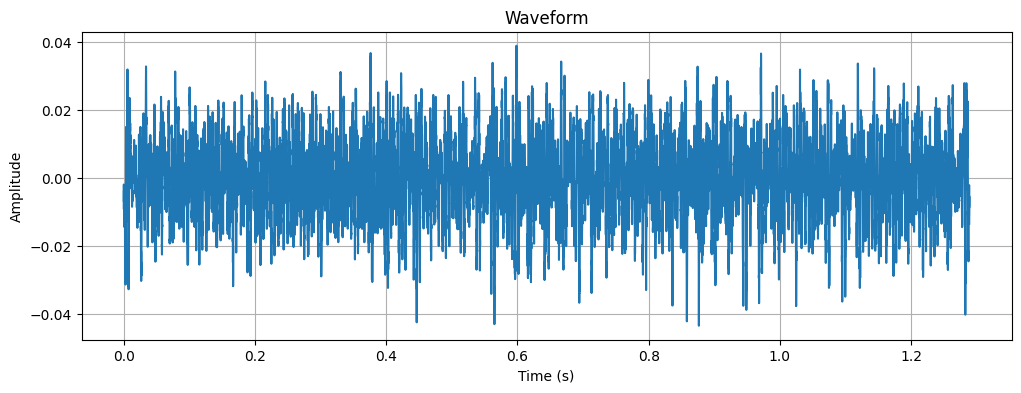

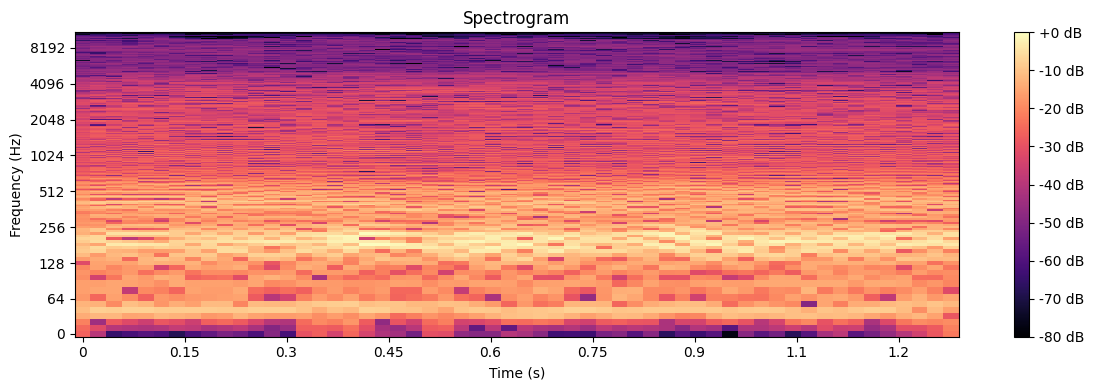

In [26]:
## Display and Show the Audio
# Load the audio file
import librosa
import librosa.display # This import is still correct and needed
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# Path to your converted audio file
converted_audio_path = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/_converted.wav"
# converted_audio_path = "/content/drive/MyDrive/AdaIN/mrh_AdaIN_Output_80bin/p225_001.wav"

# Load the audio file
y, sr = librosa.load(converted_audio_path)

# Play the audio
print("Playing audio:")
display(Audio(converted_audio_path))

# --- Display the waveform (using matplotlib.pyplot directly) ---
plt.figure(figsize=(12, 4))
# Create a time axis
time = np.linspace(0, len(y) / sr, num=len(y))
plt.plot(time, y) # Directly plot time vs. amplitude
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# --- Display the spectrogram ---
# Compute the Short-Time Fourier Transform (STFT)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

**MRH: Now we want to incorporate PESQ & STOI solver so as to caqlculate wave based metrics**

In [33]:
pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274950 sha256=b741ce120c8c3115f40d0c84693155619158f406a7b8c6b3842add970b09a1a6
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [52]:
from numpy import random
from pesq import pesq
x = random.randint(10, size=(100000))
y = random.randint(10, size=(100000))
rate=16000
##
print(pesq(rate, x, y, 'wb'))
print(pesq(rate, x, y, 'nb'))

1.2011059522628784

In [50]:
from pesq import pesq_batch
ref = random.randint(10, size=(10,100000))
deg = random.randint(10, size=(10,100000))
fs=16000
pesq_batch(fs, ref, deg, mode='wb')

[1.0761003494262695,
 1.145431399345398,
 1.1397494077682495,
 2.195140838623047,
 3.9798479080200195,
 1.2938222885131836,
 1.382366418838501,
 2.6180648803710938,
 1.0650938749313354,
 4.454090595245361]

In [53]:
pip install pystoi

  Using cached pystoi-0.4.1-py2.py3-none-any.whl.metadata (4.0 kB)
Using cached pystoi-0.4.1-py2.py3-none-any.whl (8.2 kB)


In [67]:
from pystoi import stoi
###
# clean = random.randint(1, size=(100000))
clean=random.rand(10000)
# denoised = random.randint(1, size=(100000))
denoised=random.rand(10000)
# denoised=clean
fs=22050
d = stoi(clean, denoised, fs, extended=False)
print(d)

###


-0.018630975511857266


In [93]:
# new version
import numpy as np
import scipy.signal # Import scipy for resampling
# Assuming 'pesq' and 'stoi' are imported from their respective libraries
from pesq import pesq
from pystoi.stoi import stoi

class VoiceQualityEvaluator:
    """
    A class to evaluate speech quality using PESQ and STOI metrics.
    It directly accepts NumPy arrays for audio data and handles resampling
    for PESQ if the input sample rate is different from the target.
    """

    def __init__(self, pesq_sample_rate: int = 16000):
        """
        Initializes the VoiceQualityEvaluator.

        Args:
            pesq_sample_rate (int): The sample rate that PESQ will use (typically 8kHz or 16kHz).
                                      Input audio will be resampled to this rate if necessary for PESQ.
        """
        self.pesq_sample_rate = pesq_sample_rate

    def _resample_audio(self, audio_array: np.ndarray, original_sr: int) -> np.ndarray:
        """
        Helper method to resample an audio array to the pesq_sample_rate.

        Args:
            audio_array (np.ndarray): The input audio array.
            original_sr (int): The original sample rate of the audio_array.

        Returns:
            np.ndarray: The resampled audio array.
        """
        if original_sr == self.pesq_sample_rate:
            return audio_array

        # Calculate the number of samples in the resampled audio
        num_samples_resampled = int(len(audio_array) * (self.pesq_sample_rate / original_sr))

        # Perform resampling using scipy.signal.resample
        resampled_audio = scipy.signal.resample(audio_array, num_samples_resampled)
        return resampled_audio

    def calculate_pesq(self, reference_audio: np.ndarray, degraded_audio: np.ndarray, original_sr: int) -> float:
        """
        Calculates the Perceptual Evaluation of Speech Quality (PESQ) score.
        Resamples audio to self.pesq_sample_rate if original_sr is different.

        Args:
            reference_audio (np.ndarray): The clean, original reference audio as a 1D NumPy array.
            degraded_audio (np.ndarray): The converted/degraded audio as a 1D NumPy array.
            original_sr (int): The original sample rate of both reference_audio and degraded_audio.

        Returns:
            float: The PESQ score. Returns NaN if calculation fails.
        """
        try:
            # Resample if needed for PESQ
            if original_sr != self.pesq_sample_rate:
                resampled_ref = self._resample_audio(reference_audio, original_sr)
                resampled_deg = self._resample_audio(degraded_audio, original_sr)
            else:
                resampled_ref = reference_audio
                resampled_deg = degraded_audio

            # Ensure both arrays have the same length for PESQ calculation
            min_len = min(len(resampled_ref), len(resampled_deg))
            ref_audio_clipped = resampled_ref[:min_len]
            deg_audio_clipped = resampled_deg[:min_len]

            # PESQ mode based on the target sample rate
            mode = 'wb' if self.pesq_sample_rate == 16000 else 'nb'
            score = pesq(self.pesq_sample_rate, ref_audio_clipped, deg_audio_clipped, mode)
            return score
        except Exception as e:
            # print(f"PESQ calculation failed: {e}") # Uncomment for debugging
            return np.nan

    def calculate_stoi(self, reference_audio: np.ndarray, degraded_audio: np.ndarray, original_sr: int) -> float:
        """
        Calculates the Short-Time Objective Intelligibility (STOI) score.
        STOI typically accepts various sample rates, so no internal resampling for STOI.

        Args:
            reference_audio (np.ndarray): The clean, original reference audio as a 1D NumPy array.
            degraded_audio (np.ndarray): The converted/degraded audio as a 1D NumPy array.
            original_sr (int): The original sample rate of both reference_audio and degraded_audio.

        Returns:
            float: The STOI score. Returns NaN if calculation fails.
        """
        try:
            # Ensure both arrays have the same length for STOI calculation
            min_len = min(len(reference_audio), len(degraded_audio))
            ref_audio_clipped = reference_audio[:min_len]
            deg_audio_clipped = degraded_audio[:min_len]

            # STOI accepts the original_sr directly
            score = stoi(ref_audio_clipped, deg_audio_clipped, original_sr, extended=False)
            return score
        except Exception as e:
            # print(f"STOI calculation failed: {e}") # Uncomment for debugging
            return np.nan

    def calculate_all_quality_metrics(self, reference_audio: np.ndarray, degraded_audio: np.ndarray, original_sr: int) -> tuple[float, float]:
        """
        Calculates PESQ and STOI scores for given reference and degraded audio arrays.
        Handles resampling for PESQ if original_sr differs from the pesq_sample_rate.

        Args:
            reference_audio (np.ndarray): The clean, original reference audio as a 1D NumPy array.
            degraded_audio (np.ndarray): The converted/degraded audio as a 1D NumPy array.
            original_sr (int): The original sample rate of both input audio arrays.

        Returns:
            tuple[float, float]: A tuple containing (pesq_score, stoi_score).
                                 Values will be np.nan if calculation fails.
        """
        # Pass original_sr to individual calculation methods
        pesq_score = self.calculate_pesq(reference_audio, degraded_audio, original_sr)
        stoi_score = self.calculate_stoi(reference_audio, degraded_audio, original_sr)

        return pesq_score, stoi_score

# --- Example Usage ---
# You'll need to install scipy: pip install scipy

# Scenario: Original audio at 22050 Hz, PESQ requires 16000 Hz
original_sr = 22050
pesq_sample_sr = 16000
#

reference_audio=random.rand(10000)
degraded_audio=random.rand(10000)
# degraded_audio=reference_audio

print(f"Original audio sample rate: {original_sr} Hz")
print(f"PESQ will operate at target sample rate: {pesq_sample_sr} Hz")

evaluator = VoiceQualityEvaluator(pesq_sample_rate=pesq_sample_sr)

pesq_score, stoi_score = evaluator.calculate_all_quality_metrics(
    reference_audio,
    degraded_audio,
    original_sr # Pass the original sample rate here
)

print(f"\nCalculated PESQ (resampled by class): {pesq_score:.4f}")
print(f"Calculated STOI (original SR used): {stoi_score:.4f}")

# Test with a perfect match at original_sr (scores should be high)
print("\n--- Testing Perfect Match (Original SR) ---")
pesq_score_perfect, stoi_score_perfect = evaluator.calculate_all_quality_metrics(
    reference_audio,
    reference_audio, # Perfect match
    original_sr
)
print(f"PESQ (Perfect Match): {pesq_score_perfect:.4f}")
print(f"STOI (Perfect Match): {stoi_score_perfect:.4f}")

# Test with audio already at the target PESQ sample rate (no resampling should occur)
print("\n--- Testing Audio already at Target SR (16000 Hz) ---")
sr_16k = 16000


evaluator_16k = VoiceQualityEvaluator(pesq_sample_rate=sr_16k)
pesq_16k, stoi_16k = evaluator_16k.calculate_all_quality_metrics(reference_audio, degraded_audio, sr_16k)
print(f"PESQ (16kHz input): {pesq_16k:.4f}")
print(f"STOI (16kHz input): {stoi_16k:.4f}")

Original audio sample rate: 22050 Hz
PESQ will operate at target sample rate: 16000 Hz

Calculated PESQ (resampled by class): 1.6068
Calculated STOI (original SR used): -0.0176

--- Testing Perfect Match (Original SR) ---
PESQ (Perfect Match): 4.6439
STOI (Perfect Match): 1.0000

--- Testing Audio already at Target SR (16000 Hz) ---
PESQ (16kHz input): 1.5724
STOI (16kHz input): -0.1061


In [99]:
# adaptive_voice_conversion /solver.py
import torch
import numpy as np
import sys
import os
import torch.nn as nn
import torch.nn.functional as F
import yaml
import pickle
# from model import AE
# from data_utils import get_data_loader
# from data_utils import PickleDataset
# from utils import *
from functools import reduce
from collections import defaultdict
from tqdm.auto import tqdm  ############### > MRH: change

class Solver(object):
    def __init__(self, config, args):
        # print('MRH1')
        # config store the value of hyperparameters, turn to attr by AttrDict
        self.config = config
        # print(config)
        # print('MRH2')

        # args store other information
        self.args = args
        # print(self.args)
        # print(' self.args.use_content_hierarchy = ',self.args.use_content_hierarchy)
        # print('MRH3')

        # logger to use tensorboard
        self.logger = Logger(self.args.logdir)
        # print('MRH4')

        # get dataloader
        self.get_data_loaders()
        # print('MRH5')

        # init the model with config
        self.build_model()
        # print('MRH6')
        self.save_config()
        # print('MRH7')

        if args.load_model:
            self.load_model()

        # print('MRH8')

        ############### MRH: Loss
        ae1=AE1(self.args)
        self.ae_loss_calculator = AELoss(n_speaker_levels=ae1.n_speaker_levels,
                                         n_content_levels=ae1.n_content_levels)


        ####### MRH: This is the change
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        ####
        # self.speaker_verifier = SpeakerVerificationEvaluator(device=self.args.device if hasattr(self.args, 'device') else 'cpu')
        self.speaker_verifier = SpeakerVerificationEvaluator(device)


        #################################### MRH: MCD
        # Initialize the MCD metric
        self.mcd_metric = MCDMetric(n_mfcc=20)
        # List to store MCD values for plotting
        self.mcd_values_history = [] # <-- ADD THIS LINE


        ###################################### MRH: To incorporate Inference
        if isinstance(args2.config, dict):
            config = args2.config
        else:
            # fallback if it's still a path string
            with open(args2.config) as f:
                config = yaml.load(f, Loader=yaml.SafeLoader)
        inferencer = Inferencer(config=config, args=args2)
        # inferencer.inference_from_path()

        ######################################### MRH: Audio Metrics
        pesq_sample_rate=16000
        self.VQA = VoiceQualityEvaluator(pesq_sample_rate=pesq_sample_sr)


    def save_model(self, iteration):
        # save model and discriminator and their optimizer
        torch.save(self.model.state_dict(), f'{self.args.store_model_path}.ckpt')
        torch.save(self.opt.state_dict(), f'{self.args.store_model_path}.opt')

    def save_config(self):
        with open(f'{self.args.store_model_path}.config.yaml', 'w') as f:
            yaml.dump(self.config, f)
        with open(f'{self.args.store_model_path}.args.yaml', 'w') as f:
            yaml.dump(vars(self.args), f)
        return

    def load_model(self):
        print(f'Load model from {self.args.load_model_path}')
        self.model.load_state_dict(torch.load(f'{self.args.load_model_path}.ckpt'))
        self.opt.load_state_dict(torch.load(f'{self.args.load_model_path}.opt'))
        return

    def get_data_loaders(self):
        data_dir = self.args.data_dir
        self.train_dataset = PickleDataset(os.path.join(data_dir, f'{self.args.train_set}.pkl'),
                os.path.join(data_dir, self.args.train_index_file),
                segment_size=self.config['data_loader']['segment_size'])
        self.train_loader = get_data_loader(self.train_dataset,
                frame_size=self.config['data_loader']['frame_size'],
                batch_size=self.config['data_loader']['batch_size'],
                shuffle=self.config['data_loader']['shuffle'],
                num_workers=4, drop_last=False)
        self.train_iter = infinite_iter(self.train_loader)


        ############################################ MRH: change

        # This is highly recommended for proper evaluation.
        # You would need to ensure your PickleDataset and get_data_loader
        # correctly yield (audio_features, speaker_id_or_filename)

        # self.val_dataset = PickleDataset(os.path.join(data_dir, f'{self.args.val_set}.pkl'),
        #                                  os.path.join(data_dir, self.args.val_index_file),
        #                                  segment_size=self.config['data_loader']['segment_size'])
        # self.val_loader = get_data_loader(self.val_dataset,
        #                                   frame_size=self.config['data_loader']['frame_size'],
        #                                   batch_size=self.config['data_loader']['batch_size'],
        #                                   shuffle=False, # No need to shuffle validation data
        #                                   num_workers=4, drop_last=False)
        # self.val_iter = infinite_iter(self.val_loader) # If you want to iterate infinitely


        return

    def build_model(self):
        # create model, discriminator, optimizers
        # print('---')
        # self.model = cc(AE1(self.config))
        self.model = cc(AE1(self.args))
        # print('***')
        # print(self.model)
        optimizer = self.config['optimizer']
        self.opt = torch.optim.Adam(self.model.parameters(),
                lr=optimizer['lr'], betas=(optimizer['beta1'], optimizer['beta2']),
                amsgrad=optimizer['amsgrad'], weight_decay=optimizer['weight_decay'])
        # print(self.opt)
        return
    ########################################################
    # Assuming 'model' is an instance of AE and 'batch' contains input 'x'
    # This should be part of your training loop
    # def ae_step(model, x):
    def ae_step(self,x,lambda_kl):
        x = cc(x)
        output = self.model(x)
        dec = output['dec']
        speaker_latents = output['speaker_latents']
        content_latents = output['content_latents']
        #
        loss_components = self.ae_loss_calculator.loss_calculate(x, dec, speaker_latents, content_latents, lambda_kl)
        loss= loss_components['total_loss']

        ###
        self.opt.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                max_norm=self.config['optimizer']['grad_norm'])
        self.opt.step()

        ###

        return loss_components, output

        # return {
        #     'recon_loss': recon_loss,
        #     'speaker_kld_loss': speaker_kld_loss,
        #     'content_kld_loss': content_kld_loss
        #     # You might add other relevant values here if they are directly calculated
        #     # and consistently available within ae_step (e.g., total_loss and grad_norm
        #     # if ae_step also handled optimization, but we decided against that earlier).
        # }
################################################################################
    def train(self, n_iterations):
        # print('mrh 1')
        batch_mcd = 0.0 # Initialize with a default value
        batch_mcd_dtw = 0.0
        batch_lsd=0.0
        for iteration in range(n_iterations):
            # print('mrh 2')
            # print('iteration= ',iteration)
            if iteration >= self.config['annealing_iters']:
                lambda_kl = self.config['lambda']['lambda_kl']
            else:
                lambda_kl = self.config['lambda']['lambda_kl'] * (iteration + 1) / self.config['annealing_iters']
            data = next(self.train_iter)
            # print('mrh 3')
            # print('data= ',data)
            # print('\ndata length= ',len(data))
            # print('\ndata type= ',type(data))
            # print('\ndata[0].shape=  ', data[0].shape)
            # print('\nlen(data[1])=  ', len(data[1]))

            # raise Exception('Mohammad Reza Hasanabadi')

            ######################################################### MRH: change
            # meta = self.ae_step(data, lambda_kl)
            meta , output= self.ae_step(data[0] if isinstance(data, (list, tuple)) else data, lambda_kl)


            # print('meta type = ',type(meta))
            # print('mrh 4')
            # add to logger
            if iteration % self.args.summary_steps == 0:
                # print('mrh 5')
                self.logger.scalars_summary(f'{self.args.tag}/ae_train', meta, iteration)
                # print('mrh 6')
            # loss_rec = meta['loss_rec']
            loss_rec = meta['recon_loss']
            # print('mrh 7')
            # loss_kl = meta['loss_kl']
            speaker_loss_kl = meta['speaker_kld_loss']
            content_loss_kl = meta['content_kld_loss']
            # print('mrh 8')

            # print(f'AE:[{iteration + 1}/{n_iterations}], loss_rec={loss_rec:.2f}, '
                    # f'loss_kl={loss_kl:.2f}, lambda={lambda_kl:.1e}     ', end='\r')


            if (iteration + 1) % self.args.save_steps == 0 or iteration + 1 == n_iterations:
                self.save_model(iteration=iteration)
                print()

            ############################################################################# MRH: change

            if (iteration + 1) % 5 == 0 :
                self.model.eval() # Still good practice to put model in eval mode for this

                # print('1')
                audio_data_batch = data[0] # Use the current batch's audio data
                speaker_ids_batch = data[1]                 # Use the current batch's speaker IDs

                all_embeddings = []
                all_speaker_ids = []

                # print('2')
                # with torch.no_grad():
                audio_data_batch = cc(audio_data_batch)
                # print('audio_data_batch shape =',audio_data_batch.shape)
                model_output = self.model(audio_data_batch)
                # print('22')
                embeddings_batch = model_output['speaker_latents']['decoder_input']

                # Collect individual embeddings and speaker IDs from the current batch
                print('3')
                for i in range(embeddings_batch.size(0)):
                    all_embeddings.append(embeddings_batch[i].cpu())
                    all_speaker_ids.append(speaker_ids_batch[i])

                print('4')
                try:
                    # Check if there are enough distinct speakers for a meaningful EER
                    if len(set(all_speaker_ids)) < 2 or len(all_embeddings) < 2:
                        print("Skipping batch-level speaker verification: Not enough unique speakers or samples in batch.")
                    else:
                        eval_results = self.speaker_verifier.evaluate(all_embeddings, all_speaker_ids)
                        # Log with a different tag to distinguish from full eval
                        self.logger.scalars_summary(f'{self.args.tag}/speaker_verification_batch', {
                            'eer': eval_results['eer'],
                            'roc_auc': eval_results['roc_auc'],
                            'eer_threshold': eval_results['eer_threshold']
                        }, iteration)
                        print(f"Batch Speaker Verification Results: EER={eval_results['eer']:.4f}, ROC AUC={eval_results['roc_auc']:.4f}")
                except ValueError as e:
                    print(f"Skipping batch-level speaker verification due to data inadequacy: {e}")

                self.model.train()
                print("-----------------------------------------------------------------------------------\n")
            # --- End Speaker Verification on Current Batch ---



            ###################################################### MRH: MCD
                        # Add to logger and calculate MCD only when summary_steps condition is met
            if iteration % 5 == 0:
                # self.logger.scalars_summary(f'{self.args.tag}/ae_train', meta, iteration)

                # --- Start: MCDMetric Calculation Moved Inside Summary Block ---

                # Convert PyTorch tensors to NumPy arrays for metric calculation
                # Ensure they are on CPU and detached from graph
                source_mels = data[0].cpu().detach().numpy()
                converted_mels = output['dec'].cpu().detach().numpy()

                # Calculate MCD for the current batch using the initialized mcd_metric instance
                batch_mcd = self.mcd_metric.calculate_mcd(source_mels, converted_mels)


                # Calculate MCD-DTW
                batch_mcd_dtw = self.mcd_metric.calculate_mcd_dtw(source_mels, converted_mels)

                # Calculate lsd
                batch_lsd = self.mcd_metric.calculate_lsd(source_mels, converted_mels)

                # Log MCD
                # self.logger.scalars_summary(f'{self.args.tag}/metrics/mcd', {'mcd': batch_mcd}, iteration)

                # Store the calculated MCD value
                self.mcd_values_history.append(batch_mcd) # <-- STORE HERE

                # Print the average MCD immediately
                # print(f"MCD calculated at iteration {iteration}: {batch_mcd:.4f}") # <-- PRINT HERE

                # --- End: MCDMetric Calculation Moved Inside Summary Block ---


            ####################################


            if iteration % 5 == 0:
                ###############
                # MRH: remember we do not use the model here we just used the output of model= converted_mels = output['dec']
                source_mels = data[0]
                converted_mels = output['dec']
                sample_source_wav_data, sample_target_wav_data = inferencer.mrh_inference_from_mel_spectograms(source_mels,converted_mels)
                # print('type & shape  = ',type(sample_source_wav_data), np.shape(sample_source_wav_data))
                # print('type & shape  = ',type(sample_target_wav_data), np.shape(sample_target_wav_data))
                # print(' Done ')
                pesq_score, stoi_score = self.VQA.calculate_all_quality_metrics(sample_source_wav_data,
                                                                           sample_target_wav_data,
                                                                           original_sr=22050
                )
                # print('pesq_score= ',pesq_score, 'stoi_score= ',stoi_score )





            ##################################################
            print(f'AE:[{iteration + 1}/{n_iterations}], loss_rec={meta["recon_loss"]:.2f}, '
                    f'speaker_loss_kl={meta["speaker_kld_loss"]:.2f}, content_loss_kl={meta["content_kld_loss"]:.2f} ,'
                    f'lambda={lambda_kl:.1e}, MCD={batch_mcd:.4f}, MCD_DTW={batch_mcd_dtw:.4f}, batch_lsd={batch_lsd:.4f}'
                    f' pesq_score={pesq_score:.4f}, stoi_score={stoi_score:.4f} '
                    ) # This will print 0.0 if not calculated in this iter.

        return

In [ ]:
from argparse import ArgumentParser, Namespace
import torch
# from solver import Solver # Make sure Solver is defined or imported
import yaml
import sys

# Assume your ARGS class (with the embedded config) is defined above or imported

if __name__ == '__main__':
    args1 = ARGS1() # Instantiate your ARGS class
    args2 = ARGS_TEST()

    # The config is already loaded into args.config within the ARGS __init__
    # So, you just need to assign it to a local variable 'config' if you want
    config = args1.config

    # Now, pass this 'config' dictionary to your Solver
    solver = Solver(config=config, args=args1)

    if args1.iters > 0:
        solver.train(n_iterations=args1.iters)